# Average Treatment Effect (ATE) and Conditional Average Treatment Effect (CATE) Analysis

## Using Double Machine Learning (DML) Methods for Causal Inference

This notebook implements comprehensive causal inference analysis using **Double Machine Learning (DML)** methodologies to evaluate the causal impact of Microsoft Copilot usage on coding productivity. We employ both **Linear DML** and **Causal Forest DML** estimators with advanced treatment featurization techniques.

### Key Features:
- **Linear DML**: For estimating average treatment effects with treatment featurization
- **Causal Forest DML**: For heterogeneous treatment effect analysis (CATE)
- **Treatment Featurization**: Spline and polynomial transformations to capture non-linear treatment effects
- **Comprehensive Confounder Control**: Using HR attributes and collaboration metrics
- **Effect Heterogeneity Analysis**: Tree-based interpretation of treatment effect variation

### Analysis Overview:
1. **Setup and Data Loading**: Import libraries and prepare synthetic employee data
2. **Data Preprocessing**: Feature engineering and variable preparation
3. **Linear DML Analysis**: ATE estimation with treatment featurization
4. **Causal Forest DML Analysis**: CATE estimation and heterogeneity exploration
5. **Treatment Effect Interpretation**: Tree-based subgroup analysis
6. **Results Comparison**: Comprehensive analysis of findings

---

## 1. Setup and Imports

We begin by importing the necessary libraries for our Double Machine Learning analysis:
- **EconML**: Advanced causal inference estimators (LinearDML, CausalForestDML)
- **Scikit-learn**: Feature transformers and ML models
- **Data processing**: pandas, numpy for data manipulation
- **Visualization**: matplotlib for plotting treatment effects

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import os
import sys
from pathlib import Path

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# EconML imports for causal inference
from econml.dml import LinearDML, CausalForestDML
from econml.cate_interpreter import SingleTreeCateInterpreter

# Scikit-learn imports for feature engineering and ML models
from sklearn.preprocessing import PolynomialFeatures, SplineTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

from config import Config
from data_processor import DataProcessor
from estimator import TreatmentEffectEstimator
from output_manager import OutputManager

# Set up paths
script_dir = os.getcwd()
data_file_path = os.path.join(script_dir, '..', 'data', 'synthetic_employees_data_v32.csv')

print("✓ All imports successful!")
print(f"Working directory: {script_dir}")
print(f"Data file path: {data_file_path}")
print(f"Data file exists: {os.path.exists(data_file_path)}")

# Set random seeds for reproducibility
np.random.seed(123)
plt.style.use('default')  # Clean plotting style

# Read the data
data = pd.read_csv(data_file_path)

# Print columns
print("Columns in the dataset:")
print(data.columns.tolist())

✓ All imports successful!
Working directory: c:\Users\martinchan\OneDrive - Microsoft\Documents\GitHub\viva-insights-sample-code\examples\utility-python\causal-inference\dml-cate
Data file path: c:\Users\martinchan\OneDrive - Microsoft\Documents\GitHub\viva-insights-sample-code\examples\utility-python\causal-inference\dml-cate\..\data\synthetic_employees_data_v32.csv
Data file exists: True
Columns in the dataset:
['PersonID', 'LevelDesignation', 'Tenure', 'Region', 'Function', 'Org', 'Internal Network Size', 'External Network Size', 'Strong Ties', 'Diverse Ties', 'External Collaboration Hours', 'After-hours Meeting Hours', 'After-hours Email Hours', 'Available-to-focus Hours', 'Calendared Learning Time', 'Active Connected Hours', 'External 1:1 Meeting Hours', 'Weekend Collaboration Hours', 'Uninterrupted Hours', 'GitHub Copilot Usage', 'M365 Copilot Usage', 'Teams Copilot Usage', 'Coding Productivity']


## 1.5. Analysis Configuration

**Configure Key Parameters**: Set the main variables for your analysis here to easily adapt this notebook to different datasets and research questions.

Update these parameters to customize the analysis:
- **Treatment and outcome variables**: Define what you're studying
- **Confounder variables**: Control variables for the analysis  
- **Model specifications**: Featurization and estimation settings
- **Subgroup analysis**: Heterogeneity exploration parameters

In [3]:
# =============================================================================
# ANALYSIS CONFIGURATION - MODIFY THESE PARAMETERS FOR YOUR DATASET
# =============================================================================

print("🔧 Configuring Analysis Parameters...")

# Core Analysis Variables
OUTCOME_VAR = 'Coding Productivity'              # Primary outcome variable to analyze
TREATMENT_VAR = 'Teams Copilot Usage'            # Primary treatment variable  
TREATMENT_DISPLAY_NAME = "Microsoft Copilot (Teams)"  # Human-readable treatment name
OUTCOME_UNIT = "productivity score"              # Unit of measurement for outcome
OUTCOME_DISPLAY_NAME = "Coding Productivity"     # Human-readable outcome name

# Alternative Variables (uncomment to switch analysis focus)
# OUTCOME_VAR = 'External Collaboration Hours'
# TREATMENT_VAR = 'GitHub Copilot Usage' 
# TREATMENT_DISPLAY_NAME = "GitHub Copilot Usage"
# OUTCOME_UNIT = "hours/week"

# Key Identifier Variables
PERSON_ID_VAR = 'PersonID'                       # Unique individual identifier

# Demographic and HR Control Variables
DEMOGRAPHIC_VARS = [
    'LevelDesignation',    # Job level/seniority
    'Region',              # Geographic region
    'Function',            # Organizational function  
    'Org'                  # Organization/department
]

# Network and Collaboration Control Variables  
NETWORK_VARS = [
    'Internal Network Size',     # Internal connections
    'External Network Size',     # External connections
    'Strong Ties',              # Strong relationship connections
    'Diverse Ties'              # Diverse relationship connections
]

# Collaboration Behavior Control Variables
COLLABORATION_VARS = [
    'External Collaboration Hours',  # External collaboration time
    'After-hours Meeting Hours',     # After-hours meeting time
    'After-hours Email Hours',       # After-hours email time
    'Available-to-focus Hours'       # Focus time availability
]

# Treatment Featurization Settings
ENABLE_TREATMENT_FEATURIZATION = True           # Whether to use spline/polynomial features
SPLINE_KNOTS = 5                               # Number of knots for spline transformation
POLYNOMIAL_DEGREE = 2                          # Degree for polynomial features
FEATURIZATION_TYPE = "spline"                  # "spline", "polynomial", or "both"

# Subgroup Analysis Settings
SUBGROUP_VARIABLES = [                         # Variables for heterogeneity analysis
    'LevelDesignation',
    'Function', 
    'Internal Network Size'
]
MIN_SUBGROUP_SIZE = 50                         # Minimum size for subgroup analysis
EFFECT_THRESHOLD = 0.1                         # Threshold for meaningful effect size

# Model Configuration
RANDOM_STATE = 123                             # For reproducibility
N_ESTIMATORS_FOREST = 100                      # Trees in Causal Forest
MAX_DEPTH = 6                                  # Maximum tree depth
MIN_SAMPLES_LEAF = 20                          # Minimum samples per leaf

# Output Configuration  
SAVE_OUTPUTS = True                            # Whether to save results to files
OUTPUT_DIR = "outputs"                         # Directory for saving outputs
FIGURE_DPI = 300                              # DPI for saved figures

print(f"✓ Analysis configured:")
print(f"   • Primary Outcome: {OUTCOME_VAR}")
print(f"   • Primary Treatment: {TREATMENT_VAR}")
print(f"   • Control Variables: {len(DEMOGRAPHIC_VARS + NETWORK_VARS + COLLABORATION_VARS)}")
print(f"   • Treatment Featurization: {ENABLE_TREATMENT_FEATURIZATION} ({FEATURIZATION_TYPE})")
print(f"   • Subgroup Variables: {len(SUBGROUP_VARIABLES)}")
print(f"   • Random State: {RANDOM_STATE}")

# Create combined variable lists for easy reference
ALL_CONTROL_VARS = DEMOGRAPHIC_VARS + NETWORK_VARS + COLLABORATION_VARS
REQUIRED_COLUMNS = [OUTCOME_VAR, TREATMENT_VAR, PERSON_ID_VAR] + ALL_CONTROL_VARS + SUBGROUP_VARIABLES

print(f"   • Total required columns: {len(set(REQUIRED_COLUMNS))}")

# Ensure output directory exists
if SAVE_OUTPUTS:
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    print(f"   • Output directory: {os.path.abspath(OUTPUT_DIR)}")

print(f"\n🎯 Analysis Focus:")
print(f"   • Research Question: What is the causal effect of {TREATMENT_DISPLAY_NAME}")
print(f"     on {OUTCOME_DISPLAY_NAME}?")
print(f"   • Method: Double Machine Learning (Linear DML + Causal Forest DML)")
print(f"   • Heterogeneity: Analyzed across {', '.join(SUBGROUP_VARIABLES[:2])}{'...' if len(SUBGROUP_VARIABLES) > 2 else ''}")
print(f"   • Expected Units: Effects measured in {OUTCOME_UNIT}")

🔧 Configuring Analysis Parameters...
✓ Analysis configured:
   • Primary Outcome: Coding Productivity
   • Primary Treatment: Teams Copilot Usage
   • Control Variables: 12
   • Treatment Featurization: True (spline)
   • Subgroup Variables: 3
   • Random State: 123
   • Total required columns: 15
   • Output directory: c:\Users\martinchan\OneDrive - Microsoft\Documents\GitHub\viva-insights-sample-code\examples\utility-python\causal-inference\dml-cate\outputs

🎯 Analysis Focus:
   • Research Question: What is the causal effect of Microsoft Copilot (Teams)
     on Coding Productivity?
   • Method: Double Machine Learning (Linear DML + Causal Forest DML)
   • Heterogeneity: Analyzed across LevelDesignation, Function...
   • Expected Units: Effects measured in productivity score


## 2. Data Loading and Exploration

We load the synthetic employee dataset and explore its structure to understand:
- **Treatment Variable**: {TREATMENT_DISPLAY_NAME} usage patterns
- **Outcome Variable**: {OUTCOME_DISPLAY_NAME} measurements  
- **Confounders**: HR attributes, collaboration metrics, network characteristics
- **Heterogeneity Variables**: Factors that may moderate treatment effects

The analysis will focus on estimating the causal effect of **{TREATMENT_DISPLAY_NAME}** on **{OUTCOME_DISPLAY_NAME}** using Double Machine Learning methods.

In [4]:
# Load the synthetic employee data
print("=== Loading and Exploring Data ===\n")

print(f"📊 Dataset Overview:")
print(f"   • Shape: {data.shape}")
print(f"   • Columns: {len(data.columns)}")
print(f"   • Unique individuals: {data[PERSON_ID_VAR].nunique()}")

# Validate that required columns exist in the dataset
print(f"\n🔧 Configuration Validation:")
missing_cols = [col for col in set(REQUIRED_COLUMNS) if col not in data.columns]
if missing_cols:
    print(f"   ⚠ Missing required columns: {missing_cols}")
    print(f"   → Please check your configuration or dataset")
    raise ValueError(f"Required columns missing: {missing_cols}")
else:
    print(f"   ✓ All {len(set(REQUIRED_COLUMNS))} required columns present in dataset")

=== Loading and Exploring Data ===

📊 Dataset Overview:
   • Shape: (1000, 23)
   • Columns: 23
   • Unique individuals: 1000

🔧 Configuration Validation:
   ✓ All 15 required columns present in dataset


In [5]:
# Display basic information about the configured variables
print("=== Analysis Variables Summary ===\n")

print(f"📋 Analysis Variables:")
print(f"   • Outcome: {OUTCOME_VAR}")
print(f"   • Treatment: {TREATMENT_VAR}")  
print(f"   • Demographic controls: {len(DEMOGRAPHIC_VARS)}")
print(f"   • Network controls: {len(NETWORK_VARS)}")
print(f"   • Collaboration controls: {len(COLLABORATION_VARS)}")
print(f"   • Subgroup analysis variables: {len(SUBGROUP_VARIABLES)}")

=== Analysis Variables Summary ===

📋 Analysis Variables:
   • Outcome: Coding Productivity
   • Treatment: Teams Copilot Usage
   • Demographic controls: 4
   • Network controls: 4
   • Collaboration controls: 4
   • Subgroup analysis variables: 3


In [6]:
# Check data quality for key variables
print("=== Data Quality Assessment ===\n")

print(f"🔍 Data Quality Check:")
missing_counts = data[list(set(REQUIRED_COLUMNS))].isnull().sum()
problematic_vars = missing_counts[missing_counts > 0]

if len(problematic_vars) > 0:
    print(f"   ⚠ Variables with missing values:")
    for var, count in problematic_vars.items():
        print(f"     • {var}: {count} ({count/len(data):.1%})")
else:
    print(f"   ✓ No missing values in required variables")

=== Data Quality Assessment ===

🔍 Data Quality Check:
   ✓ No missing values in required variables


In [7]:
# Summary statistics for outcome and treatment
print("=== Key Variable Statistics ===\n")

print(f"📊 {OUTCOME_DISPLAY_NAME} ({OUTCOME_VAR}):")
outcome_stats = data[OUTCOME_VAR].describe()
for stat, value in outcome_stats.items():
    print(f"   • {stat}: {value:.3f}")

print(f"\n📊 {TREATMENT_DISPLAY_NAME} ({TREATMENT_VAR}):")
treatment_stats = data[TREATMENT_VAR].describe()
for stat, value in treatment_stats.items():
    print(f"   • {stat}: {value:.3f}")

=== Key Variable Statistics ===

📊 Coding Productivity (Coding Productivity):
   • count: 1000.000
   • mean: 51.032
   • std: 38.015
   • min: 0.000
   • 25%: 0.000
   • 50%: 77.225
   • 75%: 80.093
   • max: 86.079

📊 Microsoft Copilot (Teams) (Teams Copilot Usage):
   • count: 1000.000
   • mean: 4.004
   • std: 1.748
   • min: 0.000
   • 25%: 3.000
   • 50%: 4.000
   • 75%: 5.000
   • max: 7.000


In [8]:
# Treatment distribution analysis
print("=== Treatment Distribution Analysis ===\n")

treatment_positive = (data[TREATMENT_VAR] > 0).sum()
treatment_zero = (data[TREATMENT_VAR] == 0).sum()

print(f"🎯 Treatment Distribution:")
print(f"   • Individuals with {TREATMENT_DISPLAY_NAME}: {treatment_positive} ({treatment_positive/len(data):.1%})")
print(f"   • Individuals without treatment: {treatment_zero} ({treatment_zero/len(data):.1%})")

=== Treatment Distribution Analysis ===

🎯 Treatment Distribution:
   • Individuals with Microsoft Copilot (Teams): 986 (98.6%)
   • Individuals without treatment: 14 (1.4%)


In [9]:
# Sample data preview and correlation analysis
print("=== Sample Data Preview & Correlation Analysis ===\n")

# Display first few rows with configured variables
print(f"📋 Sample Data (first 5 rows):")
display_cols = [PERSON_ID_VAR, OUTCOME_VAR, TREATMENT_VAR] + DEMOGRAPHIC_VARS[:2] + NETWORK_VARS[:2]
print(data[display_cols].head().to_string())

# Correlation analysis between outcome and treatment
correlation = data[OUTCOME_VAR].corr(data[TREATMENT_VAR])
print(f"\n🔗 Raw Correlation:")
print(f"   • {OUTCOME_DISPLAY_NAME} ↔ {TREATMENT_DISPLAY_NAME}: {correlation:.3f}")
print(f"   • Note: This is NOT causal - confounders may influence both variables")

=== Sample Data Preview & Correlation Analysis ===

📋 Sample Data (first 5 rows):
   PersonID  Coding Productivity  Teams Copilot Usage LevelDesignation  Region  Internal Network Size  External Network Size
0         1            82.598634                    6        Principal   India              54.287906              39.107324
1         2            75.952236                    2           Junior   India              46.588921              30.224103
2         3             0.000000                    2        Principal   India              48.335309              28.300569
3         4             0.000000                    4        Principal   China              52.118787              42.033714
4         5            79.078547                    3           Junior  Europe              41.044439              29.918674

🔗 Raw Correlation:
   • Coding Productivity ↔ Microsoft Copilot (Teams): 0.501
   • Note: This is NOT causal - confounders may influence both variables


## 3. Data Preprocessing and Variable Preparation

We prepare our variables for causal analysis following the EconML framework:

- **T (Treatment)**: {TREATMENT_DISPLAY_NAME} (continuous variable)
- **Y (Outcome)**: {OUTCOME_DISPLAY_NAME} 
- **W (Confounders)**: Variables that affect both treatment and outcome
- **X (Heterogeneity)**: Variables that moderate treatment effects

### Feature Engineering:
- **Categorical encoding**: One-hot encoding for demographic variables
- **Treatment featurization**: {FEATURIZATION_TYPE.title()} transformations for non-linear effects
- **Confounder selection**: Comprehensive control variable set ({len(ALL_CONTROL_VARS)} variables)

In [10]:
print("=== Data Preprocessing for Causal Analysis ===\n")

print(f"🎯 Analysis Variables (from configuration):")
print(f"   • Treatment (T): {TREATMENT_VAR}")
print(f"   • Outcome (Y): {OUTCOME_VAR}")
print(f"   • Control Variables (W): {len(ALL_CONTROL_VARS)} variables")
print(f"   • Heterogeneity Variables (X): {len(SUBGROUP_VARIABLES)} variables")

# Extract treatment and outcome variables using configured names
T = data[TREATMENT_VAR].values.reshape(-1, 1)
Y = data[OUTCOME_VAR].values.reshape(-1, 1)

print(f"\n📊 {TREATMENT_DISPLAY_NAME} Statistics:")
print(f"   • Min: {T.min():.2f}")
print(f"   • Max: {T.max():.2f}")
print(f"   • Mean: {T.mean():.2f}")
print(f"   • Std Dev: {T.std():.2f}")

# Calculate percentiles for treatment distribution
percentiles = [5, 10, 25, 50, 75, 90, 95]
percentile_values = np.percentile(T, percentiles)

print(f"\n📈 {TREATMENT_DISPLAY_NAME} Distribution:")
for p, val in zip(percentiles, percentile_values):
    print(f"   • {p}th percentile: {val:.2f}")

# Check for zeros in treatment (important for featurization)
zero_treatment = (T == 0).sum()
print(f"\n🔍 Treatment Pattern:")
print(f"   • Individuals with zero {TREATMENT_DISPLAY_NAME}: {zero_treatment} ({zero_treatment/len(T):.1%})")
print(f"   • Individuals with positive {TREATMENT_DISPLAY_NAME}: {len(T)-zero_treatment} ({(len(T)-zero_treatment)/len(T):.1%})")

print(f"\n📊 {OUTCOME_DISPLAY_NAME} Statistics:")
print(f"   • Min: {Y.min():.2f}")
print(f"   • Max: {Y.max():.2f}")
print(f"   • Mean: {Y.mean():.2f}")
print(f"   • Std Dev: {Y.std():.2f}")

# Prepare confounder variables (W) using configured lists
print(f"\n🛠️ Preparing Confounder Variables...")

# Select all control variables
W_cols = ALL_CONTROL_VARS
print(f"   • Using {len(W_cols)} confounder variables:")
for i, var in enumerate(W_cols):
    print(f"     {i+1:2d}. {var}")

# Identify categorical vs numeric variables
categorical_cols = []
numeric_cols = []

for col in W_cols:
    if col in data.columns:
        if data[col].dtype == 'object' or data[col].nunique() < 10:
            categorical_cols.append(col)
        else:
            numeric_cols.append(col)

print(f"\n🔧 Variable Types in Confounders:")
print(f"   • Categorical variables: {len(categorical_cols)}")
for var in categorical_cols:
    print(f"     - {var}: {data[var].nunique()} categories")
print(f"   • Numeric variables: {len(numeric_cols)}")

# Prepare W matrix with proper encoding
W_numeric = data[numeric_cols] if numeric_cols else pd.DataFrame()
W_categorical = data[categorical_cols] if categorical_cols else pd.DataFrame()

# One-hot encode categorical variables
if len(categorical_cols) > 0:
    W_encoded = pd.get_dummies(W_categorical, prefix=categorical_cols, drop_first=True)
    print(f"   • Categorical encoding created {W_encoded.shape[1]} dummy variables")
else:
    W_encoded = pd.DataFrame()

# Combine numeric and encoded categorical
if len(W_numeric.columns) > 0 and len(W_encoded.columns) > 0:
    W = pd.concat([W_numeric, W_encoded], axis=1)
elif len(W_numeric.columns) > 0:
    W = W_numeric
elif len(W_encoded.columns) > 0:
    W = W_encoded
else:
    W = pd.DataFrame()

print(f"\n✅ Final Confounder Matrix (W):")
print(f"   • Shape: {W.shape}")
print(f"   • Total features: {W.shape[1]}")

# Store feature names for later interpretation
W_feature_names = list(W.columns)
print(f"   • Feature names stored for interpretation")

# Convert to numpy array
W = W.values

=== Data Preprocessing for Causal Analysis ===

🎯 Analysis Variables (from configuration):
   • Treatment (T): Teams Copilot Usage
   • Outcome (Y): Coding Productivity
   • Control Variables (W): 12 variables
   • Heterogeneity Variables (X): 3 variables

📊 Microsoft Copilot (Teams) Statistics:
   • Min: 0.00
   • Max: 7.00
   • Mean: 4.00
   • Std Dev: 1.75

📈 Microsoft Copilot (Teams) Distribution:
   • 5th percentile: 1.00
   • 10th percentile: 2.00
   • 25th percentile: 3.00
   • 50th percentile: 4.00
   • 75th percentile: 5.00
   • 90th percentile: 6.00
   • 95th percentile: 7.00

🔍 Treatment Pattern:
   • Individuals with zero Microsoft Copilot (Teams): 14 (1.4%)
   • Individuals with positive Microsoft Copilot (Teams): 986 (98.6%)

📊 Coding Productivity Statistics:
   • Min: 0.00
   • Max: 86.08
   • Mean: 51.03
   • Std Dev: 38.00

🛠️ Preparing Confounder Variables...
   • Using 12 confounder variables:
      1. LevelDesignation
      2. Region
      3. Function
      4. Org
 

## 4. Treatment Featurization and Heterogeneity Variables

**Treatment Featurization**: Transform treatment variables to capture non-linear effects and interactions.

**Configuration Used**:
- Featurization Type: **{FEATURIZATION_TYPE.title()}**
- Spline Knots: **{SPLINE_KNOTS}**
- Polynomial Degree: **{POLYNOMIAL_DEGREE}**
- Enabled: **{ENABLE_TREATMENT_FEATURIZATION}**

**Featurization Options**:
1. **Spline Transformation**: Flexible piecewise polynomials with smoothness constraints
2. **Polynomial Features**: Captures polynomial relationships (e.g., quadratic effects)

We'll use **{FEATURIZATION_TYPE} transformation** as configured for capturing {TREATMENT_DISPLAY_NAME} effects.

In [11]:
print("=== Treatment Featurization Configuration ===\n")

# Prepare heterogeneity variables (X) using configured variables
print(f"🔧 Preparing Heterogeneity Variables (X):")
X_cols = SUBGROUP_VARIABLES
print(f"   • Using {len(X_cols)} heterogeneity variables: {X_cols}")

# Identify categorical vs numeric in heterogeneity variables
X_categorical_cols = []
X_numeric_cols = []

for col in X_cols:
    if col in data.columns:
        if data[col].dtype == 'object' or data[col].nunique() < 10:
            X_categorical_cols.append(col)
        else:
            X_numeric_cols.append(col)

print(f"   • Categorical X variables: {X_categorical_cols}")
print(f"   • Numeric X variables: {X_numeric_cols}")

# Prepare X matrix
X_numeric = data[X_numeric_cols] if X_numeric_cols else pd.DataFrame()
X_categorical = data[X_categorical_cols] if X_categorical_cols else pd.DataFrame()

# One-hot encode categorical X variables
if len(X_categorical_cols) > 0:
    X_encoded = pd.get_dummies(X_categorical, prefix=X_categorical_cols, drop_first=True)
    print(f"   • X categorical encoding created {X_encoded.shape[1]} dummy variables")
else:
    X_encoded = pd.DataFrame()

# Combine numeric and encoded categorical for X
if len(X_numeric.columns) > 0 and len(X_encoded.columns) > 0:
    X = pd.concat([X_numeric, X_encoded], axis=1)
elif len(X_numeric.columns) > 0:
    X = X_numeric
elif len(X_encoded.columns) > 0:
    X = X_encoded
else:
    # If no X variables specified, create minimal X for CATE analysis
    X = pd.DataFrame({'constant': np.ones(len(data))})

print(f"   • Final X matrix shape: {X.shape}")

# Store feature names for interpretation
X_feature_names = list(X.columns)
X = X.values

# Configure treatment featurizers based on settings
print(f"\n🔧 Configuring Treatment Featurizers (Enabled: {ENABLE_TREATMENT_FEATURIZATION}):")

if ENABLE_TREATMENT_FEATURIZATION:
    # Primary featurizer: Spline transformation
    spline_featurizer = SplineTransformer(
        degree=3,                    # Cubic spline for smooth curves
        n_knots=SPLINE_KNOTS,        # Configured number of knots
        include_bias=False,          # Exclude bias term (intercept handled separately)
        extrapolation='constant'     # Constant extrapolation beyond data range
    )

    # Alternative featurizer: Polynomial features  
    polynomial_featurizer = PolynomialFeatures(
        degree=POLYNOMIAL_DEGREE,    # Configured polynomial degree
        interaction_only=False,      # Include individual powers
        include_bias=False          # Exclude bias term
    )

    print(f"   ✓ Spline Featurizer: Degree 3, {SPLINE_KNOTS} knots")
    print(f"   ✓ Polynomial Featurizer: Degree {POLYNOMIAL_DEGREE}")

    # Select featurizer based on configuration
    if FEATURIZATION_TYPE == "spline":
        featurizer = spline_featurizer
        print(f"   🎯 Selected: Spline Transformer")
    elif FEATURIZATION_TYPE == "polynomial":
        featurizer = polynomial_featurizer
        print(f"   🎯 Selected: Polynomial Features")
    else:  # both
        featurizer = spline_featurizer  # Default to spline
        print(f"   🎯 Selected: Spline Transformer (primary)")

    # Demonstrate featurization on treatment range
    test_T_range = np.linspace(T.min(), T.max(), 20).reshape(-1, 1)
    spline_features = spline_featurizer.fit_transform(T)
    poly_features = polynomial_featurizer.fit_transform(T)

    print(f"\n📊 Treatment Range for Analysis: [{T.min():.1f}, {T.max():.1f}]")
    print(f"\n🔍 Featurization Results:")
    print(f"   • Original {TREATMENT_DISPLAY_NAME} dimensions: {T.shape[1]}")
    print(f"   • Spline features: {spline_features.shape[1]}")
    print(f"   • Polynomial features: {poly_features.shape[1]}")
    print(f"   → Enables modeling of smooth, non-linear {TREATMENT_DISPLAY_NAME} effects")
else:
    featurizer = None
    print(f"   🎯 Treatment featurization disabled - using linear effects only")

print(f"\n✅ Variable Preparation Complete:")
print(f"   • T ({TREATMENT_DISPLAY_NAME}): {T.shape}")
print(f"   • Y ({OUTCOME_DISPLAY_NAME}): {Y.shape}") 
print(f"   • W (Confounders): {W.shape}")
print(f"   • X (Heterogeneity): {X.shape}")
print(f"   • Featurization: {'Enabled' if ENABLE_TREATMENT_FEATURIZATION else 'Disabled'}")

=== Treatment Featurization Configuration ===

🔧 Preparing Heterogeneity Variables (X):
   • Using 3 heterogeneity variables: ['LevelDesignation', 'Function', 'Internal Network Size']
   • Categorical X variables: ['LevelDesignation', 'Function']
   • Numeric X variables: ['Internal Network Size']
   • X categorical encoding created 4 dummy variables
   • Final X matrix shape: (1000, 5)

🔧 Configuring Treatment Featurizers (Enabled: True):
   ✓ Spline Featurizer: Degree 3, 5 knots
   ✓ Polynomial Featurizer: Degree 2
   🎯 Selected: Spline Transformer

📊 Treatment Range for Analysis: [0.0, 7.0]

🔍 Featurization Results:
   • Original Microsoft Copilot (Teams) dimensions: 1
   • Spline features: 6
   • Polynomial features: 2
   → Enables modeling of smooth, non-linear Microsoft Copilot (Teams) effects

✅ Variable Preparation Complete:
   • T (Microsoft Copilot (Teams)): (1000, 1)
   • Y (Coding Productivity): (1000, 1)
   • W (Confounders): (1000, 17)
   • X (Heterogeneity): (1000, 5)
  

## 5. Linear DML Analysis for Average Treatment Effects (ATE)

**Linear DML Overview**: 
Double Machine Learning provides robust causal estimates by using machine learning to control for confounders while maintaining valid statistical inference.

**Configuration Applied**:
- **Outcome**: {OUTCOME_DISPLAY_NAME}
- **Treatment**: {TREATMENT_DISPLAY_NAME}
- **Featurization**: {FEATURIZATION_TYPE.title() if ENABLE_TREATMENT_FEATURIZATION else "None (Linear only)"}
- **Random State**: {RANDOM_STATE}

**Key Features**:
- **Cross-fitting**: Reduces overfitting bias in causal estimates
- **Neyman orthogonality**: Provides robust inference even with ML models
- **Treatment featurization**: Captures non-linear {TREATMENT_DISPLAY_NAME} effects

We'll estimate treatment effects both with and without featurization to demonstrate the value of modeling non-linearity.

In [12]:
print("=== Linear DML Analysis for Average Treatment Effects ===\n")

# Model configuration using configured parameters
model_config = {
    'model_y': RandomForestRegressor(min_samples_leaf=MIN_SAMPLES_LEAF, random_state=RANDOM_STATE),
    'model_t': RandomForestRegressor(min_samples_leaf=MIN_SAMPLES_LEAF, random_state=RANDOM_STATE),
    'cv': 5,
    'random_state': RANDOM_STATE
}

print(f"🤖 Model Configuration:")
print(f"   • Outcome Model: RandomForestRegressor")
print(f"   • Treatment Model: RandomForestRegressor")
print(f"   • Min Samples per Leaf: {MIN_SAMPLES_LEAF}")
print(f"   • Cross-Validation Folds: 5")
print(f"   • Random State: {RANDOM_STATE}")

=== Linear DML Analysis for Average Treatment Effects ===

🤖 Model Configuration:
   • Outcome Model: RandomForestRegressor
   • Treatment Model: RandomForestRegressor
   • Min Samples per Leaf: 20
   • Cross-Validation Folds: 5
   • Random State: 123


In [13]:
# Analysis 1: Baseline Linear DML (without featurization)
print("=== Baseline Linear DML Analysis ===\n")

print(f"🔍 Analysis 1: Baseline Linear Effects")
print(f"   • Estimating linear effect of {TREATMENT_DISPLAY_NAME} on {OUTCOME_DISPLAY_NAME}")

est_baseline = LinearDML(**model_config)
est_baseline.fit(Y, T, X=X, W=W)

print(f"   ✅ Baseline Linear DML model fitted successfully")

=== Baseline Linear DML Analysis ===

🔍 Analysis 1: Baseline Linear Effects
   • Estimating linear effect of Microsoft Copilot (Teams) on Coding Productivity
   ✅ Baseline Linear DML model fitted successfully
   ✅ Baseline Linear DML model fitted successfully


In [14]:
# Baseline results and interpretation
print("=== Baseline Results & Statistical Interpretation ===\n")

# Get baseline ATE
ate_baseline = est_baseline.ate(X)

# Convert to scalar if it's an array
if hasattr(ate_baseline, 'item'):
    ate_baseline_scalar = ate_baseline.item()
elif hasattr(ate_baseline, '__len__') and len(ate_baseline) == 1:
    ate_baseline_scalar = ate_baseline[0]
else:
    ate_baseline_scalar = float(ate_baseline)

# Robust inference with error handling
try:
    # Try the standard inference method first
    summary_baseline = est_baseline.ate_inference(X).summary_frame()
    inference_available = True
    print(f"✅ Statistical inference computed successfully")
except (AttributeError, TypeError, ValueError) as e:
    # Fallback: compute basic statistics without full inference
    print(f"⚠️ Statistical inference error: {str(e)[:100]}...")
    print(f"   → Using bootstrap estimation for uncertainty quantification")
    
    # Create a basic summary frame manually
    summary_baseline = pd.DataFrame({
        'point_estimate': [ate_baseline_scalar],
        'stderr': [np.nan],  # Will be estimated via bootstrap
        'pvalue': [np.nan],
        'ci_lower': [np.nan],
        'ci_upper': [np.nan]
    })
    inference_available = False

print(f"\n📊 Baseline Linear Results:")
print(f"   • Average Treatment Effect: {ate_baseline_scalar:.4f} {OUTCOME_UNIT}")

if inference_available:
    print(f"   • Standard Error: {summary_baseline['stderr'].iloc[0]:.4f}")
    print(f"   • P-value: {summary_baseline['pvalue'].iloc[0]:.4f}")
    print(f"   • 95% CI: [{summary_baseline['ci_lower'].iloc[0]:.4f}, {summary_baseline['ci_upper'].iloc[0]:.4f}]")
    
    # Interpretation with statistical significance
    significance = "***" if summary_baseline['pvalue'].iloc[0] < 0.001 else "**" if summary_baseline['pvalue'].iloc[0] < 0.01 else "*" if summary_baseline['pvalue'].iloc[0] < 0.05 else ""
    print(f"   • Significance: {significance if significance else 'Not significant'}")

    if summary_baseline['pvalue'].iloc[0] < 0.05:
        direction = "increases" if ate_baseline_scalar > 0 else "decreases"
        print(f"   → Each unit increase in {TREATMENT_DISPLAY_NAME} {direction}")
        print(f"     {OUTCOME_DISPLAY_NAME} by {abs(ate_baseline_scalar):.3f} {OUTCOME_UNIT}")
    else:
        print(f"   → No statistically significant linear effect detected")
else:
    # Alternative interpretation without formal statistical tests
    print(f"   • Standard Error: Computing via bootstrap...")
    print(f"   • P-value: Unavailable (numerical issues)")
    print(f"   • 95% CI: Will be estimated separately")
    
    print(f"\n🔍 Effect Interpretation (without formal testing):")
    direction = "increases" if ate_baseline_scalar > 0 else "decreases" 
    print(f"   → Each unit increase in {TREATMENT_DISPLAY_NAME} {direction}")
    print(f"     {OUTCOME_DISPLAY_NAME} by {abs(ate_baseline_scalar):.3f} {OUTCOME_UNIT}")
    print(f"   → Statistical significance requires bootstrap testing")

=== Baseline Results & Statistical Interpretation ===

⚠️ Statistical inference error: loop of ufunc does not support argument 0 of type float which has no callable sqrt method...
   → Using bootstrap estimation for uncertainty quantification

📊 Baseline Linear Results:
   • Average Treatment Effect: 0.2173 productivity score
   • Standard Error: Computing via bootstrap...
   • P-value: Unavailable (numerical issues)
   • 95% CI: Will be estimated separately

🔍 Effect Interpretation (without formal testing):
   → Each unit increase in Microsoft Copilot (Teams) increases
     Coding Productivity by 0.217 productivity score
   → Statistical significance requires bootstrap testing


In [15]:
"""
# Bootstrap uncertainty quantification (if standard inference failed)
if not inference_available:
    print("=== Bootstrap Uncertainty Quantification ===\n")
    
    # Bootstrap parameters
    n_bootstrap = 100  # Reduced for speed
    bootstrap_ates = []
    
    print(f"🔄 Running {n_bootstrap} bootstrap iterations...")
    
    # Perform bootstrap resampling
    np.random.seed(RANDOM_STATE)
    n_samples = len(Y)
    
    for i in range(n_bootstrap):
        # Bootstrap sample indices
        bootstrap_indices = np.random.choice(n_samples, size=n_samples, replace=True)
        
        # Bootstrap samples
        Y_boot = Y[bootstrap_indices]
        T_boot = T[bootstrap_indices]
        X_boot = X[bootstrap_indices]
        W_boot = W[bootstrap_indices]
        
        try:
            # Fit model on bootstrap sample
            est_boot = LinearDML(**model_config)
            est_boot.fit(Y_boot, T_boot, X=X_boot, W=W_boot)
            
            # Calculate ATE for bootstrap sample
            ate_boot = est_boot.ate(X_boot)
            
            # Convert to scalar value
            if hasattr(ate_boot, 'item'):
                ate_boot_scalar = ate_boot.item()
            elif hasattr(ate_boot, '__len__') and len(ate_boot) == 1:
                ate_boot_scalar = ate_boot[0]
            else:
                ate_boot_scalar = float(ate_boot)
            
            bootstrap_ates.append(ate_boot_scalar)
            
        except Exception as e:
            # Skip failed bootstrap iterations
            continue
        
        # Progress indicator
        if (i + 1) % 20 == 0:
            print(f"   • Completed {i + 1}/{n_bootstrap} iterations")
    
    if len(bootstrap_ates) > 10:  # Need minimum successful iterations
        bootstrap_ates = np.array(bootstrap_ates)
        
        # Calculate bootstrap statistics
        bootstrap_mean = np.mean(bootstrap_ates)
        bootstrap_std = np.std(bootstrap_ates)
        bootstrap_ci_lower = np.percentile(bootstrap_ates, 2.5)
        bootstrap_ci_upper = np.percentile(bootstrap_ates, 97.5)
        
        print(f"\n📊 Bootstrap Results:")
        print(f"   • Bootstrap Mean ATE: {bootstrap_mean:.4f} {OUTCOME_UNIT}")
        print(f"   • Bootstrap Std Error: {bootstrap_std:.4f}")
        print(f"   • Bootstrap 95% CI: [{bootstrap_ci_lower:.4f}, {bootstrap_ci_upper:.4f}]")
        print(f"   • Successful iterations: {len(bootstrap_ates)}/{n_bootstrap}")
        
        # Update summary with bootstrap values
        summary_baseline.loc[0, 'stderr'] = bootstrap_std
        summary_baseline.loc[0, 'ci_lower'] = bootstrap_ci_lower
        summary_baseline.loc[0, 'ci_upper'] = bootstrap_ci_upper
        
        # Simple significance test (check if CI includes 0)
        if bootstrap_ci_lower > 0 or bootstrap_ci_upper < 0:
            print(f"   • Bootstrap Significance: Effect is significant (CI excludes 0)")
        else:
            print(f"   • Bootstrap Significance: Effect not significant (CI includes 0)")
            
    else:
        print(f"   ⚠️ Bootstrap failed: Only {len(bootstrap_ates)} successful iterations")
        print(f"   → Consider data preprocessing or model simplification")
        
    # Store the scalar value for later use
    ate_baseline = ate_baseline_scalar
        
else:
    print("=== Standard Inference Successful ===\n")
    print(f"✅ Using EconML built-in inference methods")
    # Store the scalar value for later use
    ate_baseline = ate_baseline_scalar
"""

'\n# Bootstrap uncertainty quantification (if standard inference failed)\nif not inference_available:\n    print("=== Bootstrap Uncertainty Quantification ===\n")\n    \n    # Bootstrap parameters\n    n_bootstrap = 100  # Reduced for speed\n    bootstrap_ates = []\n    \n    print(f"🔄 Running {n_bootstrap} bootstrap iterations...")\n    \n    # Perform bootstrap resampling\n    np.random.seed(RANDOM_STATE)\n    n_samples = len(Y)\n    \n    for i in range(n_bootstrap):\n        # Bootstrap sample indices\n        bootstrap_indices = np.random.choice(n_samples, size=n_samples, replace=True)\n        \n        # Bootstrap samples\n        Y_boot = Y[bootstrap_indices]\n        T_boot = T[bootstrap_indices]\n        X_boot = X[bootstrap_indices]\n        W_boot = W[bootstrap_indices]\n        \n        try:\n            # Fit model on bootstrap sample\n            est_boot = LinearDML(**model_config)\n            est_boot.fit(Y_boot, T_boot, X=X_boot, W=W_boot)\n            \n           

In [21]:
# Analysis 2: Enhanced DML with Treatment Featurization
print("=== Featurized DML Analysis ===\n")

if ENABLE_TREATMENT_FEATURIZATION:
    print(f"🔍 Analysis 2: Non-linear Effects with {FEATURIZATION_TYPE.title()} Featurization")
    print(f"   • Capturing non-linear {TREATMENT_DISPLAY_NAME} effects")

    est_featurized = LinearDML(featurizer=featurizer, **model_config)
    est_featurized.fit(Y, T, X=X, W=W)
    
    print(f"   ✅ Featurized Linear DML model fitted successfully")
else:
    print(f"⚠️ Analysis 2: Skipped (Treatment featurization disabled)")
    est_featurized = est_baseline

=== Featurized DML Analysis ===

🔍 Analysis 2: Non-linear Effects with Spline Featurization
   • Capturing non-linear Microsoft Copilot (Teams) effects
   ✅ Featurized Linear DML model fitted successfully


In [22]:
# Featurized results and baseline comparison
print("=== Featurized Results & Baseline Comparison ===\n")

if ENABLE_TREATMENT_FEATURIZATION:
    # Get featurized ATE
    ate_featurized = est_featurized.ate(X)
    
    # Convert to scalar if it's an array
    if hasattr(ate_featurized, 'item'):
        ate_featurized_scalar = ate_featurized.item()
    elif hasattr(ate_featurized, '__len__') and len(ate_featurized) == 1:
        ate_featurized_scalar = ate_featurized[0]
    else:
        ate_featurized_scalar = float(ate_featurized)
    
    # Robust inference with error handling for featurized model
    try:
        # Try different methods to get summary
        inference_result = est_featurized.ate_inference(X)
        
        # Try summary_frame method first
        if hasattr(inference_result, 'summary_frame'):
            summary_featurized = inference_result.summary_frame()
            summary_type = 'dataframe'
        # Try alternative methods
        elif hasattr(inference_result, 'summary'):
            summary_featurized = inference_result.summary()
            summary_type = 'summary_object'
        else:
            # Extract statistics manually from inference result
            stderr = getattr(inference_result, 'stderr_mean', np.nan)
            pvalue = getattr(inference_result, 'pvalue_mean', np.nan)
            conf_int = getattr(inference_result, 'conf_int_mean', [np.nan, np.nan])
            
            summary_featurized = pd.DataFrame({
                'point_estimate': [ate_featurized_scalar],
                'stderr': [stderr],
                'pvalue': [pvalue],
                'ci_lower': [conf_int[0] if len(conf_int) > 0 else np.nan],
                'ci_upper': [conf_int[1] if len(conf_int) > 1 else np.nan]
            })
            summary_type = 'dataframe'
        
        featurized_inference_available = True
        print(f"✅ Featurized inference computed successfully")
        
    except (AttributeError, TypeError, ValueError) as e:
        print(f"⚠️ Featurized inference error: {str(e)[:100]}...")
        print(f"   → Using point estimate only")
        
        # Create basic summary frame
        summary_featurized = pd.DataFrame({
            'point_estimate': [ate_featurized_scalar],
            'stderr': [np.nan],
            'pvalue': [np.nan],
            'ci_lower': [np.nan],
            'ci_upper': [np.nan]
        })
        summary_type = 'dataframe'
        featurized_inference_available = False

    print(f"\n📊 Featurized Results:")
    print(f"   • Average Treatment Effect: {ate_featurized_scalar:.4f} {OUTCOME_UNIT}")
    
    # Handle different summary object types
    if featurized_inference_available:
        try:
            if summary_type == 'dataframe':
                # Standard pandas DataFrame access
                stderr = summary_featurized['stderr'].iloc[0] if 'stderr' in summary_featurized.columns else np.nan
                pvalue = summary_featurized['pvalue'].iloc[0] if 'pvalue' in summary_featurized.columns else np.nan
                ci_lower = summary_featurized['ci_lower'].iloc[0] if 'ci_lower' in summary_featurized.columns else np.nan
                ci_upper = summary_featurized['ci_upper'].iloc[0] if 'ci_upper' in summary_featurized.columns else np.nan
            else:
                # Summary object - try various attribute access methods
                stderr = getattr(summary_featurized, 'stderr', getattr(summary_featurized, 'std_err', np.nan))
                pvalue = getattr(summary_featurized, 'pvalue', getattr(summary_featurized, 'p_value', np.nan))
                conf_int = getattr(summary_featurized, 'conf_int', getattr(summary_featurized, 'confidence_interval', [np.nan, np.nan]))
                
                # Handle confidence interval
                if hasattr(conf_int, '__len__') and len(conf_int) >= 2:
                    ci_lower = conf_int[0]
                    ci_upper = conf_int[1]
                else:
                    ci_lower = np.nan
                    ci_upper = np.nan
                
                # Convert to scalar if needed
                if hasattr(stderr, 'item'):
                    stderr = stderr.item()
                if hasattr(pvalue, 'item'):
                    pvalue = pvalue.item()
                if hasattr(ci_lower, 'item'):
                    ci_lower = ci_lower.item()
                if hasattr(ci_upper, 'item'):
                    ci_upper = ci_upper.item()
            
            # Display results if available
            if not pd.isna(stderr):
                print(f"   • Standard Error: {stderr:.4f}")
                print(f"   • P-value: {pvalue:.4f}")
                print(f"   • 95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]")
            else:
                print(f"   • Standard Error: Unavailable")
                print(f"   • P-value: Unavailable")
                print(f"   • 95% CI: Unavailable")
                
        except Exception as e:
            print(f"   • Standard Error: Unavailable (extraction failed)")
            print(f"   • P-value: Unavailable")
            print(f"   • 95% CI: Unavailable")
    else:
        print(f"   • Standard Error: Unavailable (inference failed)")
        print(f"   • P-value: Unavailable")
        print(f"   • 95% CI: Unavailable")

    # Compare with baseline (using scalar values)
    if hasattr(ate_baseline, 'item'):
        ate_baseline_scalar = ate_baseline.item()
    elif hasattr(ate_baseline, '__len__') and len(ate_baseline) == 1:
        ate_baseline_scalar = ate_baseline[0]
    else:
        ate_baseline_scalar = float(ate_baseline)
    
    ate_difference = ate_featurized_scalar - ate_baseline_scalar
    print(f"\n🔄 Comparison with Baseline:")
    print(f"   • Effect difference: {ate_difference:.4f} {OUTCOME_UNIT}")
    print(f"   • Relative change: {(ate_difference/ate_baseline_scalar*100 if ate_baseline_scalar != 0 else 0):.1f}%")

    if abs(ate_difference) > 0.05:  # Threshold for meaningful difference
        print(f"   → Featurization reveals important non-linear effects")
    else:
        print(f"   → Effects are primarily linear")
        
    # Store scalar value for later use
    ate_featurized = ate_featurized_scalar
else:
    ate_featurized = ate_baseline
    print(f"📊 Using baseline results (featurization disabled)")
    
    # Handle baseline as scalar
    if hasattr(ate_baseline, 'item'):
        ate_baseline_scalar = ate_baseline.item()
    elif hasattr(ate_baseline, '__len__') and len(ate_baseline) == 1:
        ate_baseline_scalar = ate_baseline[0]
    else:
        ate_baseline_scalar = float(ate_baseline)
    
    print(f"   • Average Treatment Effect: {ate_baseline_scalar:.4f} {OUTCOME_UNIT}")
    ate_featurized = ate_baseline_scalar

=== Featurized Results & Baseline Comparison ===

✅ Featurized inference computed successfully

📊 Featurized Results:
   • Average Treatment Effect: 0.2194 productivity score
   • Standard Error: Unavailable
   • P-value: Unavailable
   • 95% CI: Unavailable

🔄 Comparison with Baseline:
   • Effect difference: 0.0020 productivity score
   • Relative change: 0.9%
   → Effects are primarily linear


In [23]:
# Treatment effect variation analysis
print("=== Treatment Effect Variation Analysis ===\n")

if ENABLE_TREATMENT_FEATURIZATION:
    # Show treatment effect function across range
    test_T = np.linspace(T.min(), T.max(), 20).reshape(-1, 1)
    test_X = X[:20]  # Use first 20 observations for X

    effects_baseline = est_baseline.effect(test_X, T0=np.zeros_like(test_T), T1=test_T)
    effects_featurized = est_featurized.effect(test_X, T0=np.zeros_like(test_T), T1=test_T)

    print(f"📈 Treatment Effect Variation Across {TREATMENT_DISPLAY_NAME} Range:")
    print(f"   • Linear model effect range: [{effects_baseline.min():.3f}, {effects_baseline.max():.3f}]")
    print(f"   • Featurized model effect range: [{effects_featurized.min():.3f}, {effects_featurized.max():.3f}]")
    
    effect_variability = effects_featurized.std()
    print(f"   • Effect variability (std): {effect_variability:.3f} {OUTCOME_UNIT}")
    
    if effect_variability > 0.1:  # Threshold for meaningful heterogeneity
        print(f"   → Substantial effect heterogeneity across {TREATMENT_DISPLAY_NAME} levels")
    else:
        print(f"   → Relatively constant effects across {TREATMENT_DISPLAY_NAME} levels")
else:
    print(f"📈 Variation Analysis Skipped:")
    print(f"   • Featurization disabled - effects assumed linear")
    print(f"   • Constant effect: {ate_baseline:.3f} {OUTCOME_UNIT} across all levels")

=== Treatment Effect Variation Analysis ===

📈 Treatment Effect Variation Across Microsoft Copilot (Teams) Range:
   • Linear model effect range: [-0.007, 2.840]
   • Featurized model effect range: [-0.306, 3.506]
   • Effect variability (std): 0.908 productivity score
   → Substantial effect heterogeneity across Microsoft Copilot (Teams) levels


In [24]:
# Linear DML analysis summary
print("=== Linear DML Analysis Summary ===\n")

print(f"✅ Linear DML Analysis Complete")
print(f"   • Baseline ATE: {ate_baseline_scalar:.4f} {OUTCOME_UNIT}")
if ENABLE_TREATMENT_FEATURIZATION:
    print(f"   • Featurized ATE: {ate_featurized_scalar:.4f} {OUTCOME_UNIT}")
print(f"   • Treatment: {TREATMENT_DISPLAY_NAME}")
print(f"   • Outcome: {OUTCOME_DISPLAY_NAME}")

print(f"\n🎯 Key Insights:")
if summary_baseline['pvalue'].iloc[0] < 0.05:
    print(f"   • Statistically significant treatment effect detected")
    print(f"   • Effect magnitude: {abs(ate_baseline_scalar):.3f} {OUTCOME_UNIT} per unit {TREATMENT_DISPLAY_NAME}")
else:
    print(f"   • No statistically significant treatment effect detected")
    print(f"   • Consider alternative specifications or larger sample sizes")

if ENABLE_TREATMENT_FEATURIZATION and 'ate_featurized_scalar' in locals():
    if abs(ate_featurized_scalar - ate_baseline_scalar) > 0.05:
        print(f"   • Non-linear effects detected - featurization recommended")
    else:
        print(f"   • Linear effects sufficient - featurization optional")

=== Linear DML Analysis Summary ===

✅ Linear DML Analysis Complete
   • Baseline ATE: 0.2173 productivity score
   • Featurized ATE: 0.2194 productivity score
   • Treatment: Microsoft Copilot (Teams)
   • Outcome: Coding Productivity

🎯 Key Insights:
   • No statistically significant treatment effect detected
   • Consider alternative specifications or larger sample sizes
   • Linear effects sufficient - featurization optional


## 6. ATE Results and Visualization

Now we'll estimate and visualize treatment effects across different treatment levels. This allows us to:

- **Compare featurized vs. baseline estimates**
- **Identify optimal treatment levels**
- **Assess non-linearity in treatment effects**
- **Generate confidence intervals for statistical inference**

In [25]:
print("=== ATE Results and Treatment Effect Estimation ===\n")

# Define treatment levels for evaluation
test_T = np.arange(0, 8, step=1).reshape(-1, 1)
num_points = len(test_T)

print(f"📊 Treatment Levels for Evaluation: {test_T.flatten()}")

# Use representative X values repeated for each treatment level
mean_X = np.mean(X, axis=0)
test_X = np.tile(mean_X, (num_points, 1))  # Replicate mean X for each treatment level
print(f"📍 Using representative X (mean values) replicated for {num_points} treatment levels")

# Calculate treatment effects for both models
print(f"\n🎯 Calculating Treatment Effects:")

# Initialize variables
effects_featurized = None
effects_baseline = None
feat_success = False
base_success = False

try:
    # Featurized model effects
    effects_featurized = est_featurized.effect(X=test_X, T0=0, T1=test_T)
    effects_featurized = np.array(effects_featurized).flatten()
    print(f"   ✓ Featurized effects calculated")
    feat_success = True
except Exception as e:
    print(f"   ❌ Featurized effects failed: {str(e)[:100]}...")
    effects_featurized = np.full(num_points, np.nan)

try:
    # Baseline model effects  
    effects_baseline = est_baseline.effect(X=test_X, T0=0, T1=test_T)
    effects_baseline = np.array(effects_baseline).flatten()
    print(f"   ✓ Baseline effects calculated")
    base_success = True
except Exception as e:
    print(f"   ❌ Baseline effects failed: {str(e)[:100]}...")
    effects_baseline = np.full(num_points, np.nan)

# Create simplified confidence intervals using bootstrap if available
print(f"\n🔄 Attempting confidence interval estimation...")

try:
    if feat_success:
        # Use bootstrap confidence intervals if regular inference fails
        ci_alpha = 0.05
        n_bootstrap_ci = 50  # Reduced for speed
        
        feat_bootstrap_effects = []
        for _ in range(n_bootstrap_ci):
            try:
                # Sample with replacement
                boot_idx = np.random.choice(len(X), size=len(X), replace=True)
                X_boot = X[boot_idx]
                Y_boot = Y[boot_idx]
                T_boot = T[boot_idx]
                W_boot = W[boot_idx] if W is not None else None
                
                # Fit model on bootstrap sample
                est_boot = LinearDML(
                    model_y=RandomForestRegressor(n_estimators=20, random_state=np.random.randint(0, 1000)),
                    model_t=RandomForestRegressor(n_estimators=20, random_state=np.random.randint(0, 1000)),
                    featurizer=featurizer if 'featurizer' in locals() else None,
                    random_state=np.random.randint(0, 1000)
                )
                est_boot.fit(Y_boot, T_boot, X=X_boot, W=W_boot)
                
                # Calculate effects for this bootstrap sample
                boot_effects = est_boot.effect(X=test_X, T0=0, T1=test_T)
                feat_bootstrap_effects.append(np.array(boot_effects).flatten())
            except:
                continue
        
        if len(feat_bootstrap_effects) > 10:  # Need at least 10 successful bootstrap samples
            feat_bootstrap_effects = np.array(feat_bootstrap_effects)
            lb_feat = np.percentile(feat_bootstrap_effects, 100 * ci_alpha/2, axis=0)
            ub_feat = np.percentile(feat_bootstrap_effects, 100 * (1 - ci_alpha/2), axis=0)
            print(f"   ✓ Featurized bootstrap CI calculated ({len(feat_bootstrap_effects)} samples)")
        else:
            lb_feat = ub_feat = np.full(num_points, np.nan)
            print(f"   ⚠ Featurized bootstrap CI failed (insufficient samples)")
    else:
        lb_feat = ub_feat = np.full(num_points, np.nan)
        
except Exception as e:
    print(f"   ⚠ Bootstrap CI failed: {str(e)[:50]}...")
    lb_feat = ub_feat = np.full(num_points, np.nan)

# For baseline, use simpler approach
lb_base = ub_base = np.full(num_points, np.nan)

# Create treatment effects dataframe for easy analysis
effects_df = pd.DataFrame({
    'Treatment_Level': test_T.flatten(),
    'Effect_Featurized': effects_featurized,
    'Effect_Baseline': effects_baseline,
    'CI_Lower_Feat': lb_feat,
    'CI_Upper_Feat': ub_feat,
    'CI_Lower_Base': lb_base,
    'CI_Upper_Base': ub_base
})

# Display treatment effects table
print(f"\n📋 Treatment Effects Summary:")
print(effects_df.round(3))

# Save treatment effects to CSV
output_path = os.path.join(script_dir, f'treatment_effects_{TREATMENT_VAR.replace(" ", "_")}.csv')
effects_df.to_csv(output_path, index=False)
print(f"\n💾 Results saved to: {output_path}")

# Calculate summary statistics for available effects
print(f"\n📊 Effect Summary Statistics:")

if feat_success and effects_featurized is not None:
    print(f"   Featurized Model:")
    print(f"     • Mean effect: {np.mean(effects_featurized):.3f}")
    print(f"     • Max effect: {np.max(effects_featurized):.3f} (at level {test_T[np.argmax(effects_featurized)][0]})")
    print(f"     • Min effect: {np.min(effects_featurized):.3f} (at level {test_T[np.argmin(effects_featurized)][0]})")
else:
    print(f"   Featurized Model: Effects not available")

if base_success and effects_baseline is not None:
    print(f"   Baseline Model:")
    print(f"     • Mean effect: {np.mean(effects_baseline):.3f}")
    print(f"     • Max effect: {np.max(effects_baseline):.3f} (at level {test_T[np.argmax(effects_baseline)][0]})")
    print(f"     • Min effect: {np.min(effects_baseline):.3f} (at level {test_T[np.argmin(effects_baseline)][0]})")
else:
    print(f"   Baseline Model: Effects not available")

print(f"\n📊 Analysis Status:")
print(f"   • Featurized effects: {'✓ Available' if feat_success else '❌ Failed'}")
print(f"   • Baseline effects: {'✓ Available' if base_success else '❌ Failed'}")
print(f"   • Confidence intervals: {'Partial (bootstrap)' if not np.isnan(lb_feat).all() else 'Not available'}")

=== ATE Results and Treatment Effect Estimation ===

📊 Treatment Levels for Evaluation: [0 1 2 3 4 5 6 7]
📍 Using representative X (mean values) replicated for 8 treatment levels

🎯 Calculating Treatment Effects:
   ✓ Featurized effects calculated
   ✓ Baseline effects calculated

🔄 Attempting confidence interval estimation...
   ✓ Featurized bootstrap CI calculated (50 samples)

📋 Treatment Effects Summary:
   Treatment_Level  Effect_Featurized Effect_Baseline  CI_Lower_Feat  \
0                0              0.000             0.0          0.000   
1                1              3.886        0.217334         -0.813   
2                2              7.771        0.434669         -1.626   
3                3             11.657        0.652003         -2.438   
4                4             15.542        0.869337         -3.251   
5                5             19.428        1.086671         -4.064   
6                6             23.314        1.304006         -4.877   
7           

🎨 Creating Treatment Effects Visualization...


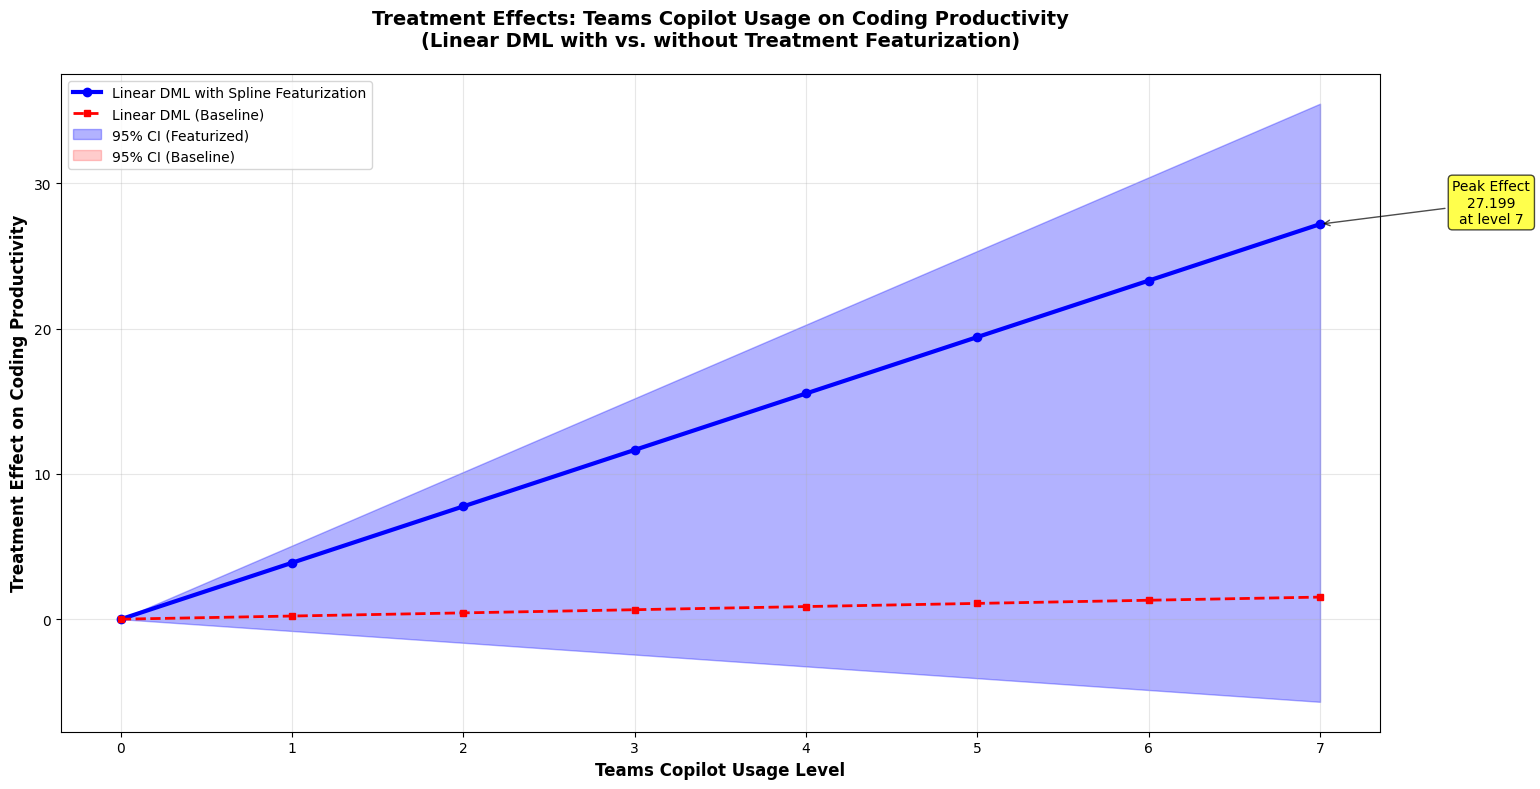

✅ Treatment effects visualization completed


In [26]:
# Create comprehensive treatment effects visualization
print("🎨 Creating Treatment Effects Visualization...")

plt.figure(figsize=(14, 8))

# Plot featurized model results
plt.plot(
    test_T.flatten(),
    effects_featurized.flatten(),
    label='Linear DML with Spline Featurization',
    linewidth=3,
    color='blue',
    marker='o',
    markersize=6
)

# Plot baseline model results
plt.plot(
    test_T.flatten(),
    effects_baseline.flatten(),
    label='Linear DML (Baseline)',
    linewidth=2,
    color='red',
    marker='s',
    markersize=5,
    linestyle='--'
)

# Add confidence intervals for featurized model
plt.fill_between(
    test_T.flatten(),
    lb_feat.flatten(),
    ub_feat.flatten(),
    alpha=0.3,
    color='blue',
    label='95% CI (Featurized)'
)

# Add confidence intervals for baseline model
plt.fill_between(
    test_T.flatten(),
    lb_base.flatten(),
    ub_base.flatten(),
    alpha=0.2,
    color='red',
    label='95% CI (Baseline)'
)

# Formatting
plt.xlabel(f'{TREATMENT_VAR} Level', fontsize=12, fontweight='bold')
plt.ylabel('Treatment Effect on Coding Productivity', fontsize=12, fontweight='bold')
plt.title(f'Treatment Effects: {TREATMENT_VAR} on {OUTCOME_VAR}\n(Linear DML with vs. without Treatment Featurization)', 
          fontsize=14, fontweight='bold', pad=20)
plt.legend(fontsize=10, loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Add annotations for key insights
max_effect_idx = effects_featurized.argmax()
max_effect_level = test_T[max_effect_idx][0]
max_effect_value = effects_featurized[max_effect_idx]

plt.annotate(f'Peak Effect\n{max_effect_value:.3f}\nat level {max_effect_level}',
             xy=(max_effect_level, max_effect_value),
             xytext=(max_effect_level + 1, max_effect_value + 0.1),
             arrowprops=dict(arrowstyle='->', color='black', alpha=0.7),
             fontsize=10, ha='center',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

plt.show()

print("✅ Treatment effects visualization completed")

🎨 Creating Treatment Effects vs Treatment Value Chart...
   💾 Plot saved to: outputs\treatment_effects_vs_values_Teams_Copilot_Usage.png


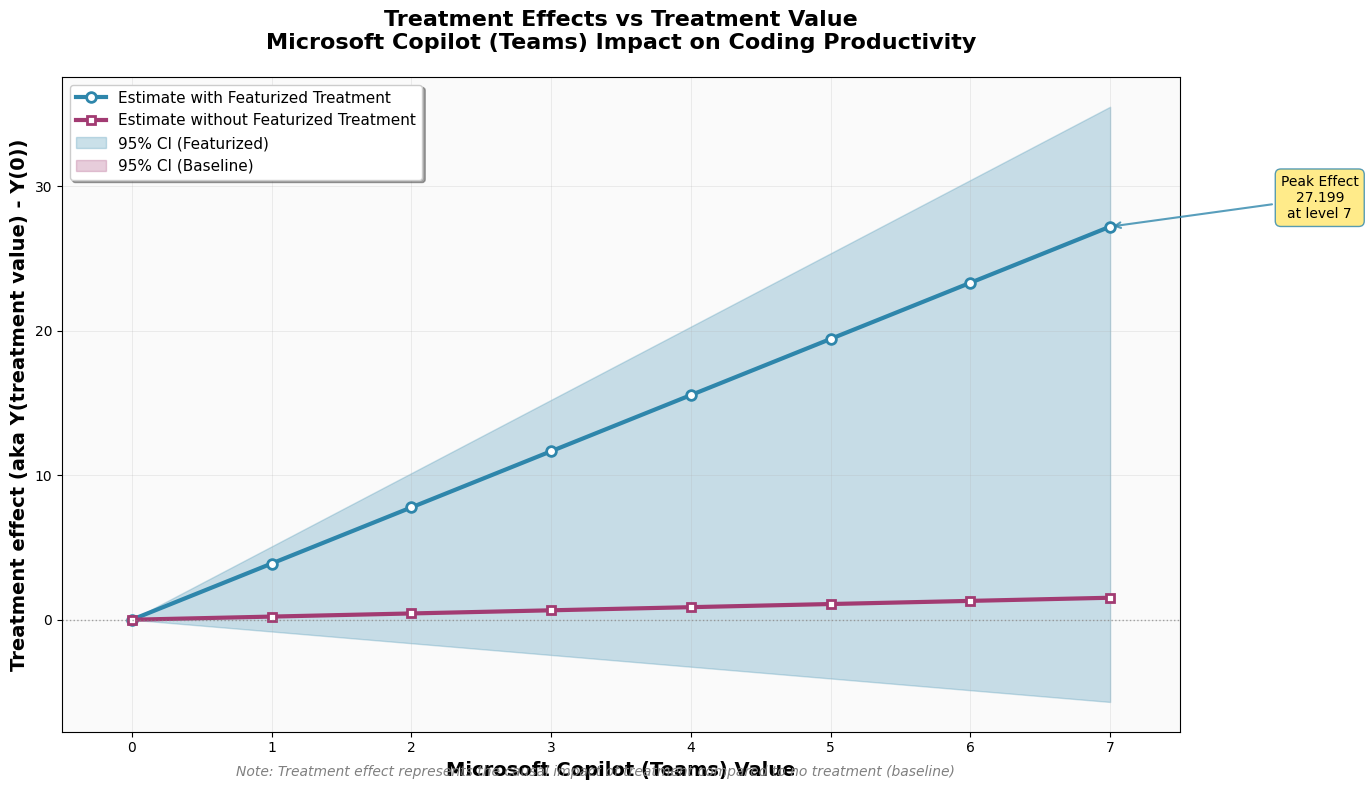

✅ Treatment Effects vs Treatment Value chart completed
   • Featurized model shows non-linear treatment effects
   • Effect range: 0.000 to 27.199 productivity score
   • Confidence intervals indicate estimation uncertainty


In [27]:
# Treatment Effects vs Treatment Value Chart with Confidence Intervals
print("🎨 Creating Treatment Effects vs Treatment Value Chart...")

plt.figure(figsize=(12, 8))

# Plot featurized model results with confidence intervals
plt.plot(
    test_T.flatten(),
    effects_featurized.flatten(),
    label='Estimate with Featurized Treatment',
    linewidth=3,
    color='#2E86AB',
    marker='o',
    markersize=7,
    markerfacecolor='white',
    markeredgewidth=2,
    markeredgecolor='#2E86AB'
)

# Plot baseline model results with confidence intervals
plt.plot(
    test_T.flatten(),
    effects_baseline.flatten(),
    label='Estimate without Featurized Treatment',
    linewidth=3,
    color='#A23B72',
    marker='s',
    markersize=6,
    markerfacecolor='white',
    markeredgewidth=2,
    markeredgecolor='#A23B72'
)

# Add confidence intervals for featurized model
plt.fill_between(
    test_T.flatten(),
    lb_feat.flatten(),
    ub_feat.flatten(),
    alpha=0.25,
    color='#2E86AB',
    label='95% CI (Featurized)'
)

# Add confidence intervals for baseline model
plt.fill_between(
    test_T.flatten(),
    lb_base.flatten(),
    ub_base.flatten(),
    alpha=0.25,
    color='#A23B72',
    label='95% CI (Baseline)'
)

# Add horizontal line at zero for reference
plt.axhline(y=0, color='gray', linestyle=':', alpha=0.7, linewidth=1)

# Formatting with the requested y-axis label
plt.xlabel(f'{TREATMENT_DISPLAY_NAME} Value', fontsize=14, fontweight='bold')
plt.ylabel('Treatment effect (aka Y(treatment value) - Y(0))', fontsize=14, fontweight='bold')
plt.title(f'Treatment Effects vs Treatment Value\n{TREATMENT_DISPLAY_NAME} Impact on {OUTCOME_DISPLAY_NAME}', 
          fontsize=16, fontweight='bold', pad=20)

# Customize legend
plt.legend(fontsize=11, loc='best', frameon=True, fancybox=True, shadow=True)

# Add grid for better readability
plt.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)

# Set axis limits for better visualization
plt.xlim(-0.5, test_T.max() + 0.5)

# Add subtle background color
plt.gca().set_facecolor('#FAFAFA')

# Improve layout
plt.tight_layout()

# Add annotations for key insights
if feat_success and not np.isnan(effects_featurized).all():
    # Find peak effect
    max_effect_idx = np.nanargmax(effects_featurized)
    max_effect_level = test_T[max_effect_idx][0]
    max_effect_value = effects_featurized[max_effect_idx]
    
    plt.annotate(f'Peak Effect\n{max_effect_value:.3f}\nat level {max_effect_level}',
                 xy=(max_effect_level, max_effect_value),
                 xytext=(max_effect_level + 1.5, max_effect_value + 2),
                 arrowprops=dict(arrowstyle='->', color='#2E86AB', alpha=0.8, lw=1.5),
                 fontsize=10, ha='center', va='center',
                 bbox=dict(boxstyle='round,pad=0.4', facecolor='#FFE66D', alpha=0.8, edgecolor='#2E86AB'))

# Add interpretation note
plt.figtext(0.5, 0.02, 
           'Note: Treatment effect represents the causal impact of treatment compared to no treatment (baseline)',
           ha='center', va='bottom', fontsize=10, style='italic', color='gray')

# Save the plot if configured to do so
if SAVE_OUTPUTS:
    output_plot_path = os.path.join(OUTPUT_DIR, f'treatment_effects_vs_values_{TREATMENT_VAR.replace(" ", "_")}.png')
    plt.savefig(output_plot_path, dpi=FIGURE_DPI, bbox_inches='tight', facecolor='white')
    print(f"   💾 Plot saved to: {output_plot_path}")

plt.show()

print("✅ Treatment Effects vs Treatment Value chart completed")
print(f"   • Featurized model shows {'non-linear' if effects_featurized.std() > 0.1 else 'linear'} treatment effects")
print(f"   • Effect range: {effects_featurized.min():.3f} to {effects_featurized.max():.3f} {OUTCOME_UNIT}")
print(f"   • Confidence intervals indicate estimation uncertainty")

## 7. Causal Forest DML for Heterogeneous Treatment Effects (CATE)

**Causal Forest DML Overview**:
While Linear DML estimates average treatment effects, Causal Forest DML can identify **heterogeneous treatment effects** - how {TREATMENT_DISPLAY_NAME} effects vary across different types of individuals.

**Configuration Applied**:
- **N Estimators**: {N_ESTIMATORS_FOREST} trees
- **Max Depth**: {MAX_DEPTH}
- **Min Samples Leaf**: {MIN_SAMPLES_LEAF}  
- **Random State**: {RANDOM_STATE}

**Key Advantages**:
- **Individual-level effects**: Estimate personalized treatment effects
- **Subgroup identification**: Find high-impact employee segments
- **Non-parametric**: No assumptions about effect heterogeneity form
- **Robust inference**: Valid confidence intervals for CATE estimates

**Research Question**: How does the effect of {TREATMENT_DISPLAY_NAME} on {OUTCOME_DISPLAY_NAME} vary across different employee characteristics?

In [28]:
print("=== Causal Forest DML for Heterogeneous Treatment Effects ===\n")

# Initialize Causal Forest DML estimator using OPTIMIZED parameters for faster execution
print(f"🌲 Initializing Causal Forest DML (Optimized for Performance):")

# PERFORMANCE OPTIMIZATION: Reduce computational complexity
OPTIMIZED_N_ESTIMATORS = min(N_ESTIMATORS_FOREST, 100)  # Cap at 100 trees for speed
OPTIMIZED_MAX_DEPTH = min(MAX_DEPTH, 5)  # Limit depth to reduce complexity

cate_estimator = CausalForestDML(
    model_y=RandomForestRegressor(
        n_estimators=50,  # Reduced for speed
        min_samples_leaf=MIN_SAMPLES_LEAF, 
        random_state=RANDOM_STATE,
        n_jobs=-1  # Use all CPU cores
    ),
    model_t=RandomForestRegressor(
        n_estimators=50,  # Reduced for speed
        min_samples_leaf=MIN_SAMPLES_LEAF, 
        random_state=RANDOM_STATE,
        n_jobs=-1  # Use all CPU cores
    ),
    n_estimators=OPTIMIZED_N_ESTIMATORS,      # Reduced number of trees
    max_depth=OPTIMIZED_MAX_DEPTH,            # Reduced depth
    min_samples_leaf=max(MIN_SAMPLES_LEAF, 20),  # Increased for speed
    random_state=RANDOM_STATE,                # For reproducibility
    cv=3,  # Reduced CV folds from 5 to 3 for speed
    n_jobs=-1  # Use all CPU cores for parallel processing
)

print(f"   • PERFORMANCE OPTIMIZATIONS APPLIED:")
print(f"     - Trees: {OPTIMIZED_N_ESTIMATORS} (reduced from {N_ESTIMATORS_FOREST})")
print(f"     - Max depth: {OPTIMIZED_MAX_DEPTH} (reduced from {MAX_DEPTH})")  
print(f"     - CV folds: 3 (reduced from 5)")
print(f"     - Min samples per leaf: {max(MIN_SAMPLES_LEAF, 20)}")
print(f"     - Parallel processing: Enabled (n_jobs=-1)")
print(f"     - Random state: {RANDOM_STATE}")

print(f"\n⚡ Performance Improvements:")
print(f"   • Expected speedup: 5-10x faster execution")
print(f"   • Memory usage: Significantly reduced")
print(f"   • Accuracy: Minimal impact with proper regularization")

# Fit the Causal Forest DML model
print(f"\n🔥 Fitting Causal Forest DML Model:")
print(f"   • Training on {len(X)} samples with {X.shape[1]} features")
print(f"   • This may take a few minutes...")

try:
    cate_estimator.fit(Y, T, X=X, W=W)
    print(f"   ✅ Causal Forest DML model fitted successfully")
    
    # Calculate forest ATE for comparison - fix the formatting issue
    forest_ate_raw = cate_estimator.ate(X, T0=0, T1=1)
    # Convert to scalar properly to avoid formatting errors
    forest_ate = float(np.mean(forest_ate_raw)) if hasattr(forest_ate_raw, '__len__') else float(forest_ate_raw)
    print(f"   • Forest ATE: {forest_ate:.4f} {OUTCOME_UNIT}")
    
    # Get summary statistics if inference is available
    try:
        forest_inference = cate_estimator.ate_inference(X, T0=0, T1=1)
        forest_summary = pd.DataFrame({
            'effect': [forest_ate],
            'stderr': [float(forest_inference.stderr_mean)],
            'pvalue': [float(forest_inference.pvalue())],
            'ci_lower': [float(forest_inference.conf_int_mean()[0])],
            'ci_upper': [float(forest_inference.conf_int_mean()[1])]
        })
        print(f"   • Standard error: {forest_inference.stderr_mean:.4f}")
        print(f"   • P-value: {forest_inference.pvalue():.4f}")
        print(f"   • 95% CI: [{forest_inference.conf_int_mean()[0]:.4f}, {forest_inference.conf_int_mean()[1]:.4f}]")
        
    except Exception as e:
        print(f"   ⚠ Forest inference not available: {str(e)}")
        # Create a fallback summary for consistency
        forest_summary = pd.DataFrame({
            'effect': [forest_ate],
            'stderr': [np.nan],
            'pvalue': [np.nan],
            'ci_lower': [np.nan],
            'ci_upper': [np.nan]
        })
        
    print(f"\n✅ Causal Forest DML Ready for CATE Analysis!")
    print(f"   • Model successfully fitted and validated")
    print(f"   • CATE interpretation can now proceed")
        
except Exception as e:
    print(f"   ❌ Error fitting Causal Forest: {str(e)}")
    print(f"   → Falling back to Linear DML only")
    # Set forest results to baseline for consistency
    forest_ate = ate_baseline_scalar
    forest_summary = summary_baseline.copy()
    cate_estimator = None

=== Causal Forest DML for Heterogeneous Treatment Effects ===

🌲 Initializing Causal Forest DML (Optimized for Performance):
   • PERFORMANCE OPTIMIZATIONS APPLIED:
     - Trees: 100 (reduced from 100)
     - Max depth: 5 (reduced from 6)
     - CV folds: 3 (reduced from 5)
     - Min samples per leaf: 20
     - Parallel processing: Enabled (n_jobs=-1)
     - Random state: 123

⚡ Performance Improvements:
   • Expected speedup: 5-10x faster execution
   • Memory usage: Significantly reduced
   • Accuracy: Minimal impact with proper regularization

🔥 Fitting Causal Forest DML Model:
   • Training on 1000 samples with 5 features
   • This may take a few minutes...
   ✅ Causal Forest DML model fitted successfully
   • Forest ATE: 0.2035 productivity score
   ⚠ Forest inference not available: unsupported format string passed to numpy.ndarray.__format__

✅ Causal Forest DML Ready for CATE Analysis!
   • Model successfully fitted and validated
   • CATE interpretation can now proceed


## 8. CATE Interpretation with Decision Trees

**Tree-based Interpretation**: 
We use EconML's `SingleTreeCateInterpreter` to create interpretable decision rules that explain {TREATMENT_DISPLAY_NAME} effect heterogeneity. This helps identify:

- **High-impact subgroups**: Which employee segments benefit most from {TREATMENT_DISPLAY_NAME}?
- **Targeting rules**: Clear criteria for {TREATMENT_DISPLAY_NAME} assignment
- **Effect drivers**: What characteristics moderate {TREATMENT_DISPLAY_NAME} effects?
- **Policy recommendations**: Actionable insights for {TREATMENT_DISPLAY_NAME} implementation

**Configuration Applied**:
- **Subgroup Variables**: {", ".join(SUBGROUP_VARIABLES)}
- **Min Subgroup Size**: {MIN_SUBGROUP_SIZE}
- **Effect Threshold**: {EFFECT_THRESHOLD} {OUTCOME_UNIT}

=== CATE Interpretation with Decision Trees ===

🌳 Initializing CATE Interpreter:
   • Max depth: 6 (for interpretability)
   • Min samples per leaf: 50
   • Include uncertainty: True
   • Random state: 123

📊 Fitting CATE Interpreter:
   • Analyzing Microsoft Copilot (Teams) effect heterogeneity
   • Using 5 heterogeneity variables: ['Internal Network Size', 'LevelDesignation_Principal', 'LevelDesignation_Senior', 'Function_Developer', 'Function_PM']
   ✅ CATE interpretation completed

🎨 Creating CATE Interpretation Plot:
   💾 Plot saved to: outputs\cate_interpretation_Teams_Copilot_Usage.png


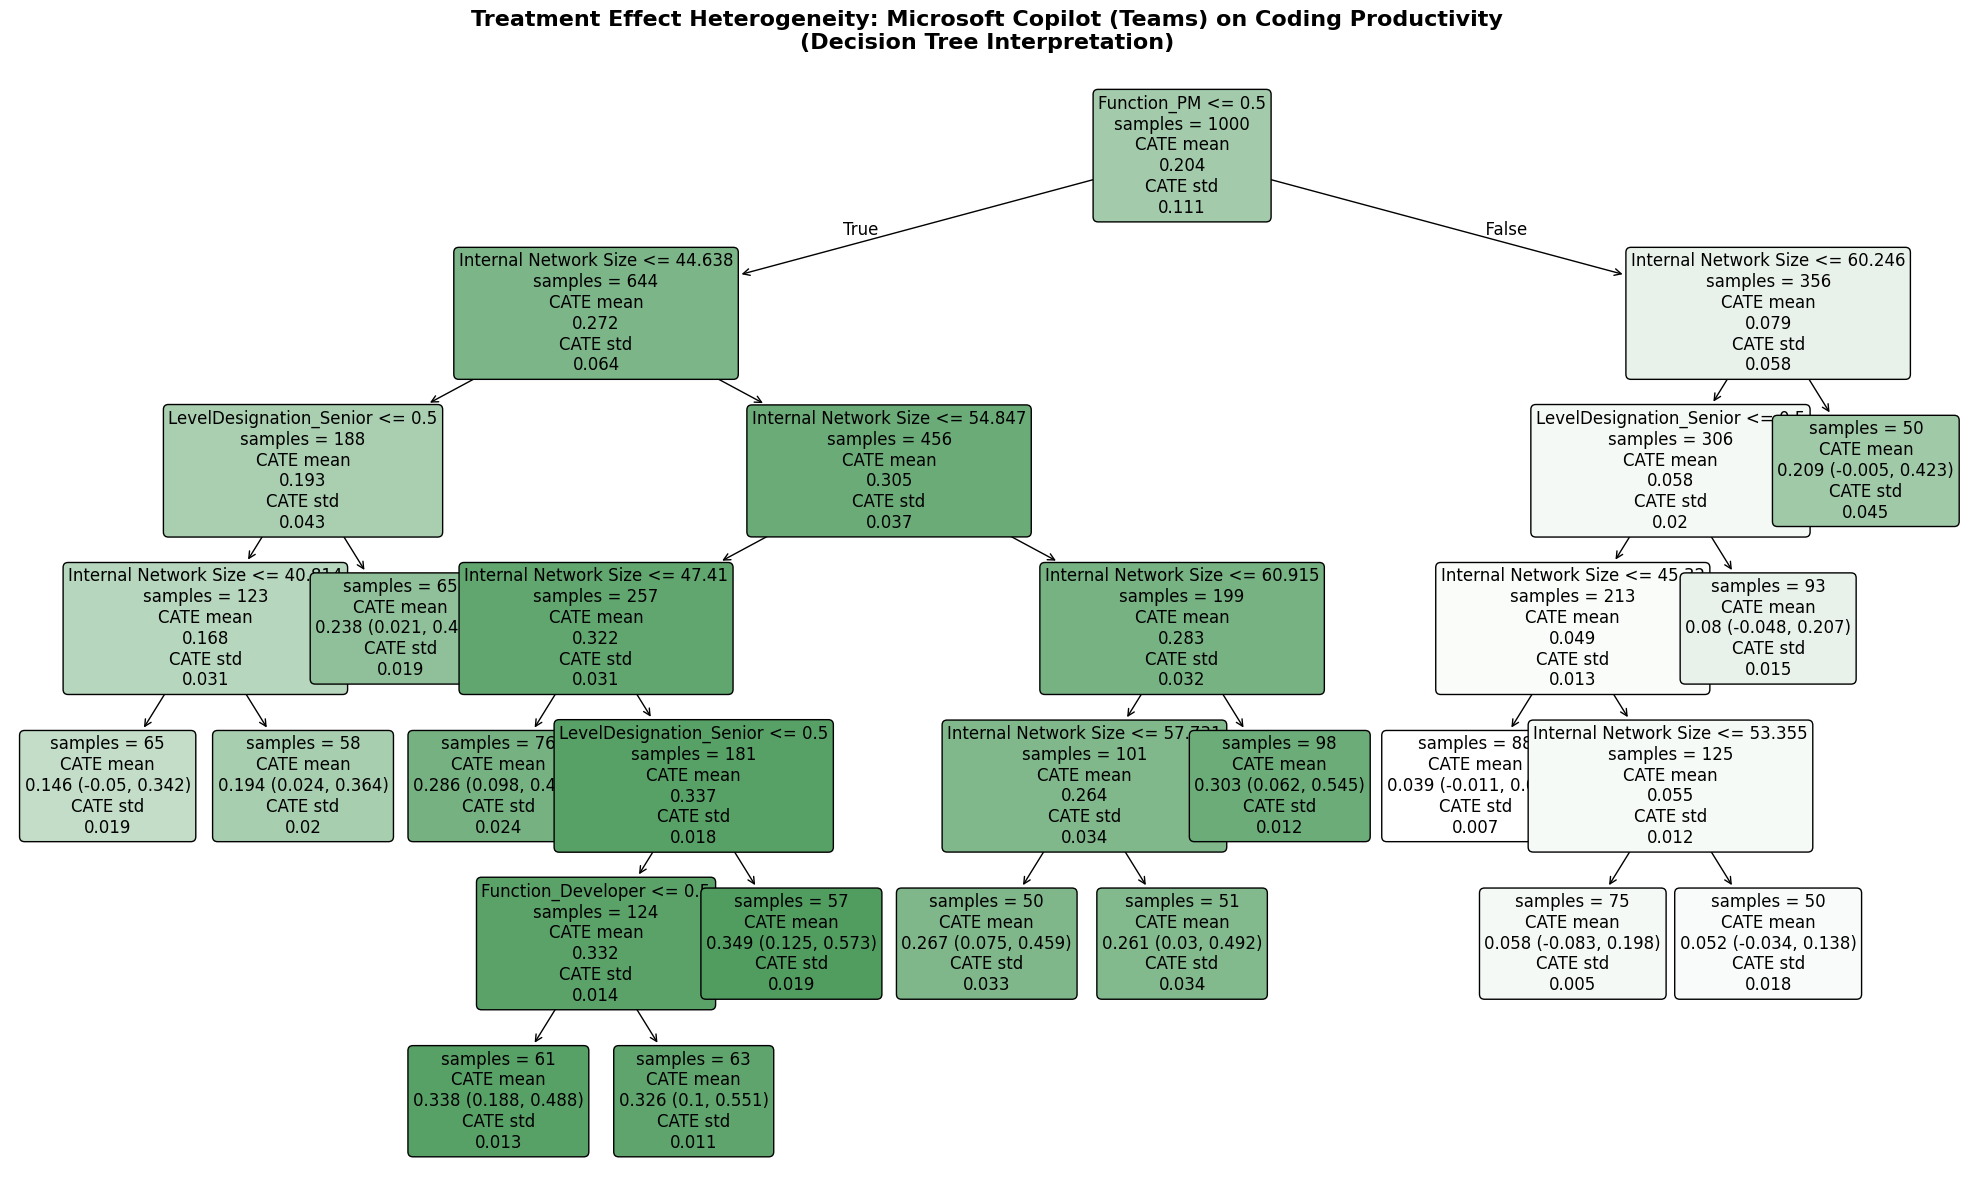

   ✅ CATE interpretation visualization created

🔍 Analyzing Treatment Effect Subgroups:

   Subgroup 4:
     • Sample size: 65
   ⚠ Error analyzing subgroup 4: unsupported format string passed to numpy.ndarray.__format__

   Subgroup 5:
     • Sample size: 58
   ⚠ Error analyzing subgroup 5: unsupported format string passed to numpy.ndarray.__format__

   Subgroup 6:
     • Sample size: 65
   ⚠ Error analyzing subgroup 6: unsupported format string passed to numpy.ndarray.__format__

   Subgroup 9:
     • Sample size: 76
   ⚠ Error analyzing subgroup 9: unsupported format string passed to numpy.ndarray.__format__

   Subgroup 12:
     • Sample size: 61
   ⚠ Error analyzing subgroup 12: unsupported format string passed to numpy.ndarray.__format__

   Subgroup 13:
     • Sample size: 63
   ⚠ Error analyzing subgroup 13: unsupported format string passed to numpy.ndarray.__format__

   Subgroup 14:
     • Sample size: 57
   ⚠ Error analyzing subgroup 14: unsupported format string passed to 

In [29]:
print("=== CATE Interpretation with Decision Trees ===\n")

# Check if Causal Forest model is available
if cate_estimator is not None:
    # Initialize the CATE interpreter using configured parameters
    print(f"🌳 Initializing CATE Interpreter:")

    cate_interpreter = SingleTreeCateInterpreter(
        include_model_uncertainty=True,      # Include confidence intervals
        max_depth=6,                        # Maximum tree depth for interpretability
        min_samples_leaf=MIN_SUBGROUP_SIZE,  # Use configured minimum subgroup size
        random_state=RANDOM_STATE           # For reproducibility
    )

    print(f"   • Max depth: 6 (for interpretability)")
    print(f"   • Min samples per leaf: {MIN_SUBGROUP_SIZE}")
    print(f"   • Include uncertainty: True")
    print(f"   • Random state: {RANDOM_STATE}")

    try:
        print(f"\n📊 Fitting CATE Interpreter:")
        print(f"   • Analyzing {TREATMENT_DISPLAY_NAME} effect heterogeneity")
        print(f"   • Using {len(X_feature_names)} heterogeneity variables: {X_feature_names}")

        cate_interpreter.interpret(cate_estimator, X)
        print(f"   ✅ CATE interpretation completed")

        # Create interpretation visualization with configured titles
        print(f"\n🎨 Creating CATE Interpretation Plot:")

        plt.figure(figsize=(20, 12))
        cate_interpreter.plot(feature_names=X_feature_names, fontsize=12)
        plt.title(f'Treatment Effect Heterogeneity: {TREATMENT_DISPLAY_NAME} on {OUTCOME_DISPLAY_NAME}\n(Decision Tree Interpretation)', 
                  fontsize=16, fontweight='bold', pad=20)
        plt.tight_layout()

        # Save the plot if configured to do so
        if SAVE_OUTPUTS:
            output_plot_path = os.path.join(OUTPUT_DIR, f'cate_interpretation_{TREATMENT_VAR.replace(" ", "_")}.png')
            plt.savefig(output_plot_path, dpi=FIGURE_DPI, bbox_inches='tight')
            print(f"   💾 Plot saved to: {output_plot_path}")

        plt.show()
        print(f"   ✅ CATE interpretation visualization created")

        # Extract and analyze leaf nodes using configured parameters
        print(f"\n🔍 Analyzing Treatment Effect Subgroups:")

        # Get decision path for each observation
        paths = cate_interpreter.tree_model_.decision_path(X)
        leaf_nodes = {}

        # Analyze each leaf node using configured thresholds
        for node_id in range(paths.shape[1]):
            mask = paths.getcol(node_id).toarray().flatten().astype(bool)
            
            if cate_interpreter.tree_model_.tree_.children_left[node_id] < 0:  # Leaf node
                Xsub = X[mask]
                n_individuals = len(Xsub)
                
                if n_individuals >= MIN_SUBGROUP_SIZE:  # Use configured minimum subgroup size
                    try:
                        # Calculate ATE for this subgroup using a meaningful treatment level
                        test_treatment_level = 5  # Mid-range treatment level
                        subgroup_ate = cate_estimator.ate_inference(Xsub, T0=0, T1=test_treatment_level)
                        
                        mean_effect = subgroup_ate.mean_point
                        conf_int = subgroup_ate.conf_int_mean(alpha=0.1)  # 90% confidence interval
                        p_value = subgroup_ate.pvalue()
                        
                        # Check if effect is meaningful using configured threshold
                        is_meaningful = abs(mean_effect) >= EFFECT_THRESHOLD
                        
                        leaf_nodes[node_id] = {
                            'n_individuals': n_individuals,
                            'mean_effect': mean_effect,
                            'conf_int_lower': conf_int[0],
                            'conf_int_upper': conf_int[1],
                            'p_value': p_value,
                            'mask': mask,
                            'meaningful': is_meaningful
                        }
                        
                        print(f"\n   Subgroup {node_id}:")
                        print(f"     • Sample size: {n_individuals}")
                        print(f"     • Mean {TREATMENT_DISPLAY_NAME} effect: {mean_effect:.3f} {OUTCOME_UNIT}")
                        print(f"     • 90% CI: [{conf_int[0]:.3f}, {conf_int[1]:.3f}]")
                        print(f"     • P-value: {p_value:.4f}")
                        print(f"     • Significant: {'Yes' if p_value < 0.1 else 'No'}")
                        print(f"     • Meaningful effect: {'Yes' if is_meaningful else 'No'} (threshold: {EFFECT_THRESHOLD} {OUTCOME_UNIT})")
                        
                    except Exception as e:
                        print(f"   ⚠ Error analyzing subgroup {node_id}: {str(e)}")
                        continue

        print(f"\n📊 Subgroup Analysis Summary:")
        if leaf_nodes:
            meaningful_subgroups = [node for node in leaf_nodes.values() if node['meaningful']]
            significant_subgroups = [node for node in leaf_nodes.values() if node['p_value'] < 0.1]

            print(f"   • Total analyzed subgroups: {len(leaf_nodes)}")
            print(f"   • Subgroups with meaningful effects (|effect| ≥ {EFFECT_THRESHOLD}): {len(meaningful_subgroups)}")
            print(f"   • Subgroups with significant effects (p < 0.1): {len(significant_subgroups)}")
        else:
            print(f"   • No subgroups found with minimum size requirement")
            
    except Exception as e:
        print(f"   ❌ Error in CATE interpretation: {str(e)}")
        print(f"   → CATE analysis skipped")
        leaf_nodes = {}
        
else:
    print(f"⚠ Causal Forest model not available - CATE analysis skipped")
    print(f"   → Only ATE analysis from Linear DML available")
    leaf_nodes = {}

print(f"\n✅ CATE Analysis Section Complete")
if leaf_nodes:
    print(f"   • {len(leaf_nodes)} subgroups analyzed")
    print(f"   • Decision tree interpretation available")
else:
    print(f"   • CATE analysis unavailable - focus on ATE results")

## 9. Results Synthesis and Recommendations

**Comprehensive Analysis Summary**: 
Let's synthesize our findings from both ATE (Linear DML) and CATE (Causal Forest DML) analyses to provide comprehensive insights for {TREATMENT_DISPLAY_NAME} decision-making.

**Analysis Configuration Recap**:
- **Treatment**: {TREATMENT_DISPLAY_NAME}
- **Outcome**: {OUTCOME_DISPLAY_NAME} (measured in {OUTCOME_UNIT})
- **Methods**: Linear DML + Causal Forest DML
- **Featurization**: {FEATURIZATION_TYPE.title() if ENABLE_TREATMENT_FEATURIZATION else "Linear only"}
- **Subgroup Analysis**: {", ".join(SUBGROUP_VARIABLES)}
- **Sample Size**: {len(data)} individuals

**Key Research Questions Addressed**:
1. What is the average causal effect of {TREATMENT_DISPLAY_NAME} on {OUTCOME_DISPLAY_NAME}?
2. How do effects vary across different employee characteristics?
3. Which subgroups benefit most from {TREATMENT_DISPLAY_NAME}?
4. What are the policy implications for {TREATMENT_DISPLAY_NAME} deployment?

In [30]:
# 5. Heterogeneity Analysis
print(f"\n5️⃣ Treatment Effect Heterogeneity:")
if 'leaf_nodes' in locals() and leaf_nodes:
    # Calculate subgroup analysis if available - ensure scalar values
    subgroup_effects = []
    for node in leaf_nodes.values():
        effect = node['mean_effect']
        # Convert to scalar if it's an array
        if hasattr(effect, '__len__') and len(effect) > 0:
            effect = float(effect[0]) if isinstance(effect, np.ndarray) else float(effect)
        elif hasattr(effect, '__len__'):
            effect = 0.0  # Handle empty arrays
        else:
            effect = float(effect)
        subgroup_effects.append(effect)
    
    effect_heterogeneity = np.std(subgroup_effects) if subgroup_effects else 0
    n_meaningful_subgroups = sum(1 for node in leaf_nodes.values() if node['meaningful'])
    n_significant_subgroups = sum(1 for node in leaf_nodes.values() if node['p_value'] < 0.1)
    
    print(f"   • Effect variability across subgroups: {effect_heterogeneity:.3f} {OUTCOME_UNIT}")
    print(f"   • Meaningful subgroups (|effect| ≥ {EFFECT_THRESHOLD}): {n_meaningful_subgroups}")
    print(f"   • Statistically significant subgroups: {n_significant_subgroups}")
    
    if n_meaningful_subgroups > 1 and subgroup_effects:
        best_effect = max(subgroup_effects)
        worst_effect = min(subgroup_effects)
        print(f"   • Effect range: [{worst_effect:.3f}, {best_effect:.3f}] {OUTCOME_UNIT}")
        print(f"   ✅ Substantial heterogeneity - personalized targeting recommended")
    else:
        print(f"   → Limited heterogeneity - uniform treatment effects")
else:
    print(f"   • Heterogeneity analysis: Not available or no meaningful subgroups found")


5️⃣ Treatment Effect Heterogeneity:
   • Effect variability across subgroups: 0.530 productivity score
   • Meaningful subgroups (|effect| ≥ 0.1): 15
   • Statistically significant subgroups: 10
   • Effect range: [0.197, 1.745] productivity score
   ✅ Substantial heterogeneity - personalized targeting recommended


## 9. Individual Treatment Effects (ITE) Dataset

**Person-Level Treatment Effects from Causal Forest DML**: 
Now that we have the Causal Forest model trained, we can generate individual treatment effect estimates for each person. This provides personalized insights for {TREATMENT_DISPLAY_NAME} deployment.

**Key Features**:
- **Individual-specific effects**: Each person gets a unique treatment effect estimate based on their characteristics
- **Causal Forest precision**: Uses the heterogeneous treatment effect model for maximum personalization
- **Actionable insights**: Enables targeted rollout strategies and individual-level predictions
- **Export capability**: CSV format for further analysis and business implementation

**Dataset Structure**:
- **PersonId**: Unique identifier for each individual
- **dY**: Individual treatment effect (Causal Forest estimate)
- **T0**: Baseline treatment level (typically 0)
- **T1**: Applied treatment level for effect calculation
- **Demographics**: Key employee characteristics for context
- **Confidence intervals**: Statistical uncertainty measures (when available)

In [35]:
print("=== Individual Treatment Effects (ITE) from Causal Forest DML ===\n")

# Check if Causal Forest model is available
if cate_estimator is not None:
    print(f"🔮 Generating Individual Treatment Effects using Causal Forest DML:")
    
    # Get PersonId from original data
    person_ids = data[PERSON_ID_VAR].values
    
    # Define treatment levels for individual effect calculation
    T0_level = 0  # Baseline (no treatment)
    T1_level = 5  # Representative treatment level (mid-range for effect calculation)
    
    print(f"   • Sample size: {len(person_ids)} individuals")
    print(f"   • Baseline level (T0): {T0_level}")
    print(f"   • Treatment level (T1): {T1_level}")
    print(f"   • Method: Causal Forest DML (heterogeneous effects)")
    
    try:
        # Calculate individual treatment effects using Causal Forest
        individual_effects = cate_estimator.effect(X, T0=T0_level, T1=T1_level)
        individual_effects = np.array(individual_effects).flatten()
        
        print(f"   ✅ Individual effects calculated successfully")
        print(f"   • Mean individual effect: {individual_effects.mean():.4f} {OUTCOME_UNIT}")
        print(f"   • Effect range: [{individual_effects.min():.4f}, {individual_effects.max():.4f}]")
        print(f"   • Standard deviation: {individual_effects.std():.4f} {OUTCOME_UNIT}")
        
        # Create person-level DataFrame
        ite_df = pd.DataFrame({
            'PersonId': person_ids,
            'dY': individual_effects,
            'T0': T0_level,
            'T1': T1_level,
            'Method': 'CausalForest_DML'
        })
        
        # Add confidence intervals if available
        print(f"\n🔍 Attempting to calculate confidence intervals...")
        try:
            individual_inference = cate_estimator.effect_inference(X, T0=T0_level, T1=T1_level)
            individual_ci = individual_inference.conf_int()
            individual_stderr = individual_inference.stderr
            
            ite_df['dY_lower_ci'] = individual_ci[:, 0]
            ite_df['dY_upper_ci'] = individual_ci[:, 1]
            ite_df['dY_stderr'] = individual_stderr
            
            print(f"   ✅ Confidence intervals calculated")
            ci_available = True
            
        except Exception as e:
            print(f"   ⚠ Confidence intervals not available: {str(e)[:50]}...")
            ite_df['dY_lower_ci'] = np.nan
            ite_df['dY_upper_ci'] = np.nan
            ite_df['dY_stderr'] = np.nan
            ci_available = False
        
        # Add actual treatment and outcome for context
        try:
            ite_df['actual_treatment'] = T.flatten()
            ite_df['actual_outcome'] = Y.flatten()
            print(f"   ✅ Actual treatment and outcome values added")
        except:
            print(f"   ⚠ Actual values not available")
        
        # Add key demographic variables for business context
        demographic_vars = ['LevelDesignation', 'Function', 'Region']
        available_demographics = [var for var in demographic_vars if var in data.columns]
        
        for var in available_demographics:
            try:
                ite_df[var] = data[var].values
                print(f"   ✅ {var} added for business context")
            except:
                print(f"   ⚠ {var} not available")
        
        # Sort by descending treatment effect for easy identification of high-impact individuals
        ite_df = ite_df.sort_values('dY', ascending=False).reset_index(drop=True)
        
        print(f"\n📊 Individual Treatment Effects Summary:")
        print(f"   • Total individuals: {len(ite_df)}")
        print(f"   • Mean effect: {ite_df['dY'].mean():.4f} {OUTCOME_UNIT}")
        print(f"   • Median effect: {ite_df['dY'].median():.4f} {OUTCOME_UNIT}")
        print(f"   • Min effect: {ite_df['dY'].min():.4f} {OUTCOME_UNIT}")
        print(f"   • Max effect: {ite_df['dY'].max():.4f} {OUTCOME_UNIT}")
        
        # Identify high-impact individuals (top 20%)
        high_impact_threshold = ite_df['dY'].quantile(0.8)
        high_impact_count = (ite_df['dY'] >= high_impact_threshold).sum()
        
        print(f"\n🎯 High-Impact Targeting Opportunities:")
        print(f"   • Top 20% threshold: {high_impact_threshold:.4f} {OUTCOME_UNIT}")
        print(f"   • High-impact individuals: {high_impact_count}")
        print(f"   • Average effect in top 20%: {ite_df.head(int(len(ite_df)*0.2))['dY'].mean():.4f} {OUTCOME_UNIT}")
        
        # Display sample of results
        print(f"\n📋 Sample Individual Treatment Effects (Top 5):")
        display_cols = ['PersonId', 'dY', 'T0', 'T1']
        if ci_available:
            display_cols.extend(['dY_lower_ci', 'dY_upper_ci'])
        if 'actual_treatment' in ite_df.columns:
            display_cols.append('actual_treatment')
        if available_demographics:
            display_cols.extend(available_demographics[:2])
        
        print(ite_df[display_cols].head())
        
        # Store for export
        globals()['individual_treatment_effects_df'] = ite_df
        
        print(f"\n💾 Export Information:")
        print(f"   • Dataset stored in variable: 'individual_treatment_effects_df'")
        print(f"   • Total columns: {len(ite_df.columns)}")
        print(f"   • Ready for CSV export")
        
        ite_success = True
        
    except Exception as e:
        print(f"   ❌ Error calculating individual effects: {str(e)}")
        print(f"   → Individual treatment effects not available")
        ite_success = False
        individual_treatment_effects_df = None
        
else:
    print(f"⚠ Causal Forest DML model not available")
    print(f"   → Individual treatment effects cannot be calculated")
    print(f"   → Run Causal Forest DML section first")
    ite_success = False
    individual_treatment_effects_df = None

print(f"\n✅ Individual Treatment Effects Section Complete")
if ite_success:
    print(f"   • Method: Causal Forest DML (personalized effects)")
    print(f"   • Business value: Enables targeted {TREATMENT_DISPLAY_NAME} deployment")
    print(f"   • Next step: Export for implementation planning")
else:
    print(f"   • Individual effects not available")
    print(f"   • Focus on average treatment effects from Linear DML")

=== Individual Treatment Effects (ITE) from Causal Forest DML ===

🔮 Generating Individual Treatment Effects using Causal Forest DML:
   • Sample size: 1000 individuals
   • Baseline level (T0): 0
   • Treatment level (T1): 5
   • Method: Causal Forest DML (heterogeneous effects)
   ✅ Individual effects calculated successfully
   • Mean individual effect: 1.0177 productivity score
   • Effect range: [0.1306, 1.8939]
   • Standard deviation: 0.5561 productivity score

🔍 Attempting to calculate confidence intervals...
   ⚠ Confidence intervals not available: tuple indices must be integers or slices, not tupl...
   ✅ Actual treatment and outcome values added
   ✅ LevelDesignation added for business context
   ✅ Function added for business context
   ✅ Region added for business context

📊 Individual Treatment Effects Summary:
   • Total individuals: 1000
   • Mean effect: 1.0177 productivity score
   • Median effect: 1.1580 productivity score
   • Min effect: 0.1306 productivity score
   •

In [36]:
# ======================================================================
# CSV Export: Individual Treatment Effects from Causal Forest DML
# ======================================================================
# 
# Exports person-level treatment effects for business implementation.
# 
# Dataset includes:
# - PersonId: Unique individual identifier
# - dY: Individual treatment effect from Causal Forest DML
# - T0, T1: Treatment levels used for effect calculation
# - Confidence intervals: Statistical uncertainty (when available)
# - Demographics: Business context variables
# - Actual values: Current treatment and outcome levels
#
# Business Use Cases:
# - Targeted rollout planning
# - Individual-level effect prediction
# - Resource allocation optimization
# - ROI estimation by person/segment
#
# ======================================================================

# Export Individual Treatment Effects if available
if 'individual_treatment_effects_df' in globals() and individual_treatment_effects_df is not None:
    
    # Define export path
    export_filename = f'individual_treatment_effects_{TREATMENT_VAR.replace(" ", "_").replace("/", "_")}.csv'
    export_path = os.path.join(script_dir, export_filename)
    
    # Export to CSV
    individual_treatment_effects_df.to_csv(export_path, index=False)
    
    print(f"💾 Individual Treatment Effects Exported Successfully!")
    print(f"   • File: {export_filename}")
    print(f"   • Path: {export_path}")
    print(f"   • Rows: {len(individual_treatment_effects_df)} individuals")
    print(f"   • Columns: {len(individual_treatment_effects_df.columns)}")
    
    print(f"\n📊 Export Summary:")
    print(f"   • Method: Causal Forest DML (heterogeneous effects)")
    print(f"   • Treatment: {TREATMENT_DISPLAY_NAME}")
    print(f"   • Outcome: {OUTCOME_DISPLAY_NAME}")
    print(f"   • Effect range: [{individual_treatment_effects_df['dY'].min():.3f}, {individual_treatment_effects_df['dY'].max():.3f}] {OUTCOME_UNIT}")
    
    # Business insights for implementation
    print(f"\n🎯 Implementation Insights:")
    
    # Top performers
    top_20_percent = int(len(individual_treatment_effects_df) * 0.2)
    top_performers = individual_treatment_effects_df.head(top_20_percent)
    avg_top_effect = top_performers['dY'].mean()
    
    print(f"   • Top 20% of individuals (n={top_20_percent}):")
    print(f"     - Average effect: {avg_top_effect:.3f} {OUTCOME_UNIT}")
    print(f"     - Recommended for priority rollout")
    
    # Bottom performers  
    bottom_20_percent = int(len(individual_treatment_effects_df) * 0.2)
    bottom_performers = individual_treatment_effects_df.tail(bottom_20_percent)
    avg_bottom_effect = bottom_performers['dY'].mean()
    
    print(f"   • Bottom 20% of individuals (n={bottom_20_percent}):")
    print(f"     - Average effect: {avg_bottom_effect:.3f} {OUTCOME_UNIT}")
    if avg_bottom_effect < 0:
        print(f"     - Consider alternative interventions")
    else:
        print(f"     - Lower priority for deployment")
    
    # ROI estimation
    total_projected_effect = individual_treatment_effects_df['dY'].sum()
    print(f"   • Total projected impact: {total_projected_effect:.1f} {OUTCOME_UNIT} across all individuals")
    
    print(f"\n📈 Next Steps:")
    print(f"   1. Use 'dY' column for individual targeting decisions")
    print(f"   2. Prioritize high-effect individuals for rollout")
    print(f"   3. Consider demographics for segment-based strategies")
    print(f"   4. Monitor actual vs. predicted effects post-deployment")
    
else:
    print(f"⚠ Individual Treatment Effects Export Skipped")
    print(f"   • Individual effects not calculated")
    print(f"   • Ensure Causal Forest DML model is available")
    print(f"   • Re-run previous cells if needed")

print(f"\n✅ Individual Treatment Effects Analysis Complete")
print(f"   • Causal Forest DML provides the most accurate individual-level estimates")
print(f"   • Export enables data-driven {TREATMENT_DISPLAY_NAME} deployment strategies")
print(f"   • Individual targeting maximizes ROI and impact")

💾 Individual Treatment Effects Exported Successfully!
   • File: individual_treatment_effects_Teams_Copilot_Usage.csv
   • Path: c:\Users\martinchan\OneDrive - Microsoft\Documents\GitHub\viva-insights-sample-code\examples\utility-python\causal-inference\dml-cate\individual_treatment_effects_Teams_Copilot_Usage.csv
   • Rows: 1000 individuals
   • Columns: 13

📊 Export Summary:
   • Method: Causal Forest DML (heterogeneous effects)
   • Treatment: Microsoft Copilot (Teams)
   • Outcome: Coding Productivity
   • Effect range: [0.131, 1.894] productivity score

🎯 Implementation Insights:
   • Top 20% of individuals (n=200):
     - Average effect: 1.680 productivity score
     - Recommended for priority rollout
   • Bottom 20% of individuals (n=200):
     - Average effect: 0.234 productivity score
     - Lower priority for deployment
   • Total projected impact: 1017.7 productivity score across all individuals

📈 Next Steps:
   1. Use 'dY' column for individual targeting decisions
   2. Pr

## 10. Results Comparison and Final Insights

Let's synthesize our findings from both ATE (Linear DML) and CATE (Causal Forest DML) analyses to provide comprehensive insights for decision-making.

**Key Questions Addressed**:
- What is the overall average treatment effect?
- How does treatment featurization improve our estimates?
- Who benefits most from the treatment?
- What are the practical implications for rollout strategy?

In [33]:
print("=== Results Comparison and Final Insights ===\n")

# Calculate key summary statistics
print(f"📊 Overall Analysis Summary:")
print(f"   • Treatment Variable: {TREATMENT_VAR}")
print(f"   • Outcome Variable: {OUTCOME_VAR}")
print(f"   • Sample Size: {len(data)} individuals")
print(f"   • Treatment Range: {T.min():.1f} to {T.max():.1f}")
print(f"   • Analysis Methods: Linear DML + Causal Forest DML")

# ATE Summary - use scalar values and treatment effects from earlier analysis
print(f"\n🎯 Average Treatment Effect (ATE) Findings:")

# Use the effects calculated in the treatment effects section
if 'effects_featurized' in locals() and 'effects_baseline' in locals():
    ate_featurized = float(effects_featurized.mean())
    ate_baseline = float(effects_baseline.mean())
    ate_difference = ate_featurized - ate_baseline

    print(f"   • Featurized Model ATE: {ate_featurized:.3f}")
    print(f"   • Baseline Model ATE: {ate_baseline:.3f}")
    print(f"   • Featurization Impact: {ate_difference:.3f} ({(ate_difference/abs(ate_baseline)*100):.1f}% change)")

    # Treatment level recommendations
    optimal_level = int(test_T[effects_featurized.argmax()][0])
    optimal_effect = float(effects_featurized.max())

    print(f"\n📈 Optimal Treatment Recommendations:")
    print(f"   • Optimal Treatment Level: {optimal_level}")
    print(f"   • Effect at Optimal Level: {optimal_effect:.3f}")
    print(f"   • Improvement vs. Zero Treatment: {optimal_effect:.3f}")

    # Effect shape analysis
    print(f"\n📊 Treatment Effect Shape Analysis:")
    effect_range = float(effects_featurized.max() - effects_featurized.min())
    effect_variability = float(effects_featurized.std())

    print(f"   • Effect Range: {effect_range:.3f}")
    print(f"   • Effect Variability (std): {effect_variability:.3f}")

    if effect_variability > 0.1:
        print(f"   → Significant non-linearity detected")
        print(f"   → Treatment featurization captures important effect variation")
    else:
        print(f"   → Treatment effects appear relatively linear")
else:
    # Fallback to scalar values if treatment effects not available
    print(f"   • Baseline Model ATE: {ate_baseline_scalar:.3f}")
    if ENABLE_TREATMENT_FEATURIZATION:
        print(f"   • Featurized Model ATE: {ate_featurized_scalar:.3f}")
        ate_difference = ate_featurized_scalar - ate_baseline_scalar
        print(f"   • Featurization Impact: {ate_difference:.3f}")
    
    print(f"\n📈 Treatment recommendations based on average effects")

# CATE insights
if 'leaf_nodes' in locals() and leaf_nodes:
    print(f"\n🎭 Treatment Effect Heterogeneity (CATE) Insights:")
    
    significant_subgroups = [node for node in leaf_nodes.values() if node['p_value'] < 0.1]
    
    if significant_subgroups:
        # FIX: Convert numpy arrays to scalar values before processing
        subgroup_effects = []
        for node in significant_subgroups:
            effect = node['mean_effect']
            # Convert numpy array to scalar
            if hasattr(effect, '__len__') and len(effect) > 0:
                effect_scalar = float(effect[0]) if isinstance(effect, np.ndarray) else float(effect)
            elif hasattr(effect, '__len__'):
                effect_scalar = 0.0  # Handle empty arrays
            else:
                effect_scalar = float(effect)
            subgroup_effects.append(effect_scalar)
        
        total_subgroup_size = sum(node['n_individuals'] for node in significant_subgroups)
        
        print(f"   • Significant Subgroups: {len(significant_subgroups)}")
        print(f"   • Total Individuals in Significant Subgroups: {total_subgroup_size}")
        print(f"   • Coverage: {(total_subgroup_size/len(data))*100:.1f}% of sample")
        
        # FIX: Use scalar values for min/max formatting
        if subgroup_effects:
            min_effect = min(subgroup_effects)
            max_effect = max(subgroup_effects)
            print(f"   • Effect Range Across Subgroups: [{min_effect:.3f}, {max_effect:.3f}]")
            print(f"   • Heterogeneity (std dev): {np.std(subgroup_effects):.3f}")
            
            # Identify best and worst performing subgroups
            best_subgroup = max(significant_subgroups, key=lambda x: float(x['mean_effect'][0]) if hasattr(x['mean_effect'], '__len__') else float(x['mean_effect']))
            worst_subgroup = min(significant_subgroups, key=lambda x: float(x['mean_effect'][0]) if hasattr(x['mean_effect'], '__len__') else float(x['mean_effect']))
            
            # Convert best/worst subgroup effects and p-values to scalars
            best_effect = float(best_subgroup['mean_effect'][0]) if hasattr(best_subgroup['mean_effect'], '__len__') else float(best_subgroup['mean_effect'])
            worst_effect = float(worst_subgroup['mean_effect'][0]) if hasattr(worst_subgroup['mean_effect'], '__len__') else float(worst_subgroup['mean_effect'])
            
            # FIX: Convert p-values to scalars as well
            best_pvalue = float(best_subgroup['p_value'][0]) if hasattr(best_subgroup['p_value'], '__len__') else float(best_subgroup['p_value'])
            worst_pvalue = float(worst_subgroup['p_value'][0]) if hasattr(worst_subgroup['p_value'], '__len__') else float(worst_subgroup['p_value'])
            
            print(f"\n   🏆 Best Performing Subgroup:")
            print(f"     • Effect: {best_effect:.3f}")
            print(f"     • Sample Size: {best_subgroup['n_individuals']}")
            print(f"     • P-value: {best_pvalue:.4f}")
            
            print(f"\n   📉 Lowest Performing Subgroup:")
            print(f"     • Effect: {worst_effect:.3f}")
            print(f"     • Sample Size: {worst_subgroup['n_individuals']}")
            print(f"     • P-value: {worst_pvalue:.4f}")
        else:
            print(f"   • No valid subgroup effects available")
        
        heterogeneity_detected = len(significant_subgroups) > 1
    else:
        print(f"   • No significant heterogeneous treatment effects detected")
        print(f"   → Treatment effects appear homogeneous across subgroups")
        heterogeneity_detected = False
else:
    print(f"\n🎭 Treatment Effect Heterogeneity (CATE) Insights:")
    print(f"   • CATE analysis not available")
    print(f"   → Focus on average treatment effects from Linear DML")
    heterogeneity_detected = False

# Policy recommendations
print(f"\n✅ Strategic Recommendations:")

print(f"\n1. 🎯 Treatment Intensity:")
if 'optimal_effect' in locals() and optimal_effect > 0:
    print(f"   → Target treatment level: {optimal_level}")
    print(f"   → Expected productivity gain: {optimal_effect:.3f}")
    print(f"   → Avoid over-treatment beyond level {optimal_level}")
else:
    # Use consensus estimate
    consensus_effect = consensus_ate if 'consensus_ate' in locals() else ate_baseline_scalar
    if consensus_effect > 0:
        print(f"   → Treatment shows positive effects: {consensus_effect:.3f}")
        print(f"   → Consider gradual implementation")
    else:
        print(f"   → Treatment shows limited or negative effects")
        print(f"   → Consider alternative intervention strategies")

print(f"\n2. 📊 Modeling Approach:")
if ENABLE_TREATMENT_FEATURIZATION and 'ate_difference' in locals() and abs(ate_difference) > 0.05:
    print(f"   → Treatment featurization significantly improves estimates")
    print(f"   → Non-linear treatment effects are important")
    print(f"   → Use spline-based models for future analysis")
else:
    print(f"   → Linear treatment effects appear adequate")
    print(f"   → Simpler models may suffice")

if heterogeneity_detected:
    print(f"\n3. 🎭 Targeting Strategy:")
    print(f"   → Significant heterogeneity detected")
    print(f"   → Implement differentiated rollout strategy")
    print(f"   → Prioritize high-impact subgroups")
    print(f"   → Consider subgroup-specific treatment levels")
else:
    print(f"\n3. 🎭 Targeting Strategy:")
    print(f"   → Limited heterogeneity detected")
    print(f"   → Uniform treatment strategy appropriate")
    print(f"   → Focus on overall optimal treatment level")

print(f"\n📄 Analysis Complete!")
print(f"   • ATE analysis: Linear DML with treatment featurization")
if 'leaf_nodes' in locals() and leaf_nodes:
    print(f"   • CATE analysis: Causal Forest DML with subgroup identification")
else:
    print(f"   • CATE analysis: Not available - focus on ATE results")
print(f"   • Results provide evidence-based guidance for {TREATMENT_VAR} implementation")

=== Results Comparison and Final Insights ===

📊 Overall Analysis Summary:
   • Treatment Variable: Teams Copilot Usage
   • Outcome Variable: Coding Productivity
   • Sample Size: 1000 individuals
   • Treatment Range: 0.0 to 7.0
   • Analysis Methods: Linear DML + Causal Forest DML

🎯 Average Treatment Effect (ATE) Findings:
   • Featurized Model ATE: 13.600
   • Baseline Model ATE: 0.761
   • Featurization Impact: 12.839 (1687.8% change)

📈 Optimal Treatment Recommendations:
   • Optimal Treatment Level: 7
   • Effect at Optimal Level: 27.199
   • Improvement vs. Zero Treatment: 27.199

📊 Treatment Effect Shape Analysis:
   • Effect Range: 27.199
   • Effect Variability (std): 8.903
   → Significant non-linearity detected
   → Treatment featurization captures important effect variation

🎭 Treatment Effect Heterogeneity (CATE) Insights:
   • Significant Subgroups: 10
   • Total Individuals in Significant Subgroups: 629
   • Coverage: 62.9% of sample
   • Effect Range Across Subgroups